<a href="https://colab.research.google.com/github/NatP-dev/Case_06/blob/main/Daily_Interest_Rates_Data_Analysis_27052025_1915.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Daily Interest Rates**

#### **Author**: Group X

## **<font color='#474747'>0 - Imports**</font>



In [24]:
################################ LIBRARIES ########################
# -------------------------- Core Libraries -------------------------- #
import os
import pandas as pd
import re
from IPython.display import display


# -------------------------- Plotting -------------------------- #
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.stats import zscore
import plotly.graph_objects as go
from collections import Counter
from collections import defaultdict



---
---
<br><br>
# **<font color='#000058'>Chapter 1: Data</font>**

## **<font color='#474747'>1.1 - Load All Data Files**

In [3]:
# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Step 2: Set the path to your folder containing the 31 CSV files
# Replace this path with the actual folder path inside your Drive
folder_path = '/content/drive/MyDrive/EMAS 14 Case 6/Data/Interest Rates/Daily'


In [5]:
# Step 3: Load all CSV files into a list of DataFrames
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Optional: Sort filenames to maintain a consistent order
csv_files.sort()

In [6]:
# Step 4: Read all CSV files
dataframes = []
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes.append(df)

# Now `dataframes` is a list of 31 DataFrames (one per CSV)
# Example: access the first DataFrame
print(dataframes[0].head())

          Unnamed: 0 BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A  \
0                NaN  Term structure of interest rates on listed Fed...      
1            Comment  Monatsendstandsreihe: WZ9807. Bis Juli 1997 li...      
2           Decimals                                                  2      
3   Time format code                                                P1D      
4  Unit (in english)                                            percent      

  BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A_FLAGS  
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           


In [7]:
# Loop for files into their own dataframes
for i in range(len(dataframes)):
    print(f"DataFrame {i}: {csv_files[i]}")

DataFrame 0: daily-term-structure-spot-interest-rate-R005X.csv
DataFrame 1: daily-term-structure-spot-interest-rate-R01XX.csv
DataFrame 2: daily-term-structure-spot-interest-rate-R02XX.csv
DataFrame 3: daily-term-structure-spot-interest-rate-R03XX.csv
DataFrame 4: daily-term-structure-spot-interest-rate-R04XX.csv
DataFrame 5: daily-term-structure-spot-interest-rate-R05XX.csv
DataFrame 6: daily-term-structure-spot-interest-rate-R06XX.csv
DataFrame 7: daily-term-structure-spot-interest-rate-R07XX.csv
DataFrame 8: daily-term-structure-spot-interest-rate-R08XX.csv
DataFrame 9: daily-term-structure-spot-interest-rate-R09XX.csv
DataFrame 10: daily-term-structure-spot-interest-rate-R10XX.csv
DataFrame 11: daily-term-structure-spot-interest-rate-R11XX.csv
DataFrame 12: daily-term-structure-spot-interest-rate-R12XX.csv
DataFrame 13: daily-term-structure-spot-interest-rate-R13XX.csv
DataFrame 14: daily-term-structure-spot-interest-rate-R14XX.csv
DataFrame 15: daily-term-structure-spot-interest-r

### **<font color='#474747'>*1.1 - Format Dataframes Consistently*</font>**
What was done to format the files:
1. Start at row 11
2. Have no headers
3. Rename columns:
  * Column 1: Date (convert to datetime)
  * Column 2: Value (float, 2 decimals)
  * Column 3: Info message like "No value available"
4. Add a new column FileReferenceName with the filename.



In [8]:
# Step 5: Read all CSVs from row 11 onward, format consistently
dataframes = []

for file in csv_files:
    full_path = os.path.join(folder_path, file)

    df = pd.read_csv(full_path, skiprows=10, header=None, dtype=str, encoding='utf-8')
    df.columns = ["Date", "Interest Rate", "Information No IR"]

    # Clean and parse columns
    df["Date"] = df["Date"].str.strip()
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
    df["Interest Rate"] = pd.to_numeric(df["Interest Rate"], errors="coerce")
    df["FileReferenceName"] = file

    dataframes.append(df)


### EXTRA: Add Maturity Column (in case needed for modeling)
# Extract Maturity number from filename and add as new column
for df in dataframes:
    match = re.search(r"R(\d+)X", df["FileReferenceName"].iloc[0])
    if match:
        df["Maturity"] = int(match.group(1))  # convert to integer like 5
    else:
        df["Maturity"] = None  # fallback if pattern not found


In [9]:
# CHECK DATA MANUALLY (Ensure alignment with excels)
# Head
display(dataframes[0].head(5))

# Tail
display(dataframes[0].tail(5))

Date  Interest Rate   Information No IR  \
0 1997-08-01            NaN  No value available   
1 1997-08-02            NaN  No value available   
2 1997-08-03            NaN  No value available   
3 1997-08-04            NaN  No value available   
4 1997-08-05            NaN  No value available   

                                   FileReferenceName  Maturity  
0  daily-term-structure-spot-interest-rate-R005X.csv         5  
1  daily-term-structure-spot-interest-rate-R005X.csv         5  
2  daily-term-structure-spot-interest-rate-R005X.csv         5  
3  daily-term-structure-spot-interest-rate-R005X.csv         5  
4  daily-term-structure-spot-interest-rate-R005X.csv         5

Date  Interest Rate   Information No IR  \
10145 2025-05-11            NaN  No value available   
10146 2025-05-12           1.93                 NaN   
10147 2025-05-13           1.95                 NaN   
10148 2025-05-14           1.94                 NaN   
10149 2025-05-15           1.93                 NaN   

                                       FileReferenceName  Maturity  
10145  daily-term-structure-spot-interest-rate-R005X.csv         5  
10146  daily-term-structure-spot-interest-rate-R005X.csv         5  
10147  daily-term-structure-spot-interest-rate-R005X.csv         5  
10148  daily-term-structure-spot-interest-rate-R005X.csv         5  
10149  daily-term-structure-spot-interest-rate-R005X.csv         5

## **<font color='#474747'>1.2 - Data Pre-processing**

In [10]:
### INFORMATION ON DATA PER FILE
# Collect info summary per DataFrame
summary_rows = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"(R\d+X)", file_name)
    maturity_label = match.group(1) if match else file_name

    row = {"Daily Spot Interest Rate": maturity_label, "Rows": len(df)}

    for col in df.columns:
        row[f"{col} | Non-Null"] = df[col].notnull().sum()
        row[f"{col} | Dtype"] = str(df[col].dtype)

    summary_rows.append(row)

# Create summary table
summary_df = pd.DataFrame(summary_rows)
summary_df.set_index("Daily Spot Interest Rate", inplace=True)
summary_df = summary_df.sort_index()

# Display in notebook (nicely formatted)
from IPython.display import display
display(summary_df)


Rows  Date | Non-Null    Date | Dtype  \
Daily Spot Interest Rate                                           
R005X                     10150            10150  datetime64[ns]   
R01X                      10150            10150  datetime64[ns]   
R02X                      10150            10150  datetime64[ns]   
R03X                      10150            10150  datetime64[ns]   
R04X                      10150            10150  datetime64[ns]   
R05X                      10150            10150  datetime64[ns]   
R06X                      10150            10150  datetime64[ns]   
R07X                      10150            10150  datetime64[ns]   
R08X                      10150            10150  datetime64[ns]   
R09X                      10150            10150  datetime64[ns]   
R10X                      10150            10150  datetime64[ns]   
R11X                      10149            10149  datetime64[ns]   
R12X                      10149            10149  datetime64[ns]   
R13X                      10149            10149  datetime64[ns]   
R14X                      10149            10149  datetime64[ns]   
R15X                      10149            10149  datetime64[ns]   
R16X                      10149            10149  datetime64[ns]   
R17X                      10149            10149  datetime64[ns]   
R18X                      10149            10149  datetime64[ns]   
R19X                      10149            10149  datetime64[ns]   
R20X                      10149            10149  datetime64[ns]   
R21X                       9053             9053  datetime64[ns]   
R22X                       9053             9053  datetime64[ns]   
R23X                       9053             9053  datetime64[ns]   
R24X                       9053             9053  datetime64[ns]   
R25X                       9053             9053  datetime64[ns]   
R26X                       9053             9053  datetime64[ns]   
R27X                       9053             9053  datetime64[ns]   
R28X                       9053             9053  datetime64[ns]   
R29X                       9053             9053  datetime64[ns]   
R30X                       9053             9053  datetime64[ns]   

                          Interest Rate | Non-Null Interest Rate | Dtype  \
Daily Spot Interest Rate                                                   
R005X                                         7048               float64   
R01X                                          7048               float64   
R02X                                          7048               float64   
R03X                                          7048               float64   
R04X                                          7048               float64   
R05X                                          7048               float64   
R06X                                          7048               float64   
R07X                                          7048               float64   
R08X                                          7048               float64   
R09X                                          7048               float64   
R10X                                          7048               float64   
R11X                                          7048               float64   
R12X                                          7048               float64   
R13X                                          7048               float64   
R14X                                          7048               float64   
R15X                                          7048               float64   
R16X                                          7048               float64   
R17X                                          7048               float64   
R18X                                          7048               float64   
R19X                                          7048               float64   
R20X                                          7048               float64   
R21X                              

In [11]:
### DESCRIBE() DATA
for i, df in enumerate(dataframes):
    # Get file/maturity label
    file_name = df["FileReferenceName"].iloc[0]
    maturity = re.search(r"(R\d+X)", file_name).group(1)

    print(f"\n--- Summary Statistics for {maturity} ({file_name}) ---")
    print(df.describe())



--- Summary Statistics for R005X (daily-term-structure-spot-interest-rate-R005X.csv) ---
                                Date  Interest Rate  Maturity
count                          10150    7048.000000   10150.0
mean   2011-06-23 11:59:59.999999744       1.520241       5.0
min              1997-08-01 00:00:00      -0.980000       5.0
25%              2004-07-12 06:00:00      -0.250000       5.0
50%              2011-06-23 12:00:00       1.655000       5.0
75%              2018-06-03 18:00:00       3.322500       5.0
max              2025-05-15 00:00:00       5.120000       5.0
std                              NaN       1.833644       0.0

--- Summary Statistics for R01X (daily-term-structure-spot-interest-rate-R01XX.csv) ---
                                Date  Interest Rate  Maturity
count                          10150    7048.000000   10150.0
mean   2011-06-23 11:59:59.999999744       1.564343       1.0
min              1997-08-01 00:00:00      -0.970000       1.0
25%            

In [15]:
### SUMMARIZE DESCRIE() OF INTEREST RATE VALUES INTO ONE TABLE
import pandas as pd
import re
from IPython.display import display

summary_rows = []

for df in dataframes:
    # Extract maturity label (e.g. R005X)
    file_name = df["FileReferenceName"].iloc[0]
    maturity = re.search(r"(R\d+X)", file_name).group(1)

    # Get describe for Value only
    stats = df[["Interest Rate"]].describe().T  # Transpose to get single row per maturity
    stats["Maturity Interest Rate"] = maturity
    summary_rows.append(stats)

# Combine all rows
summary_df = pd.concat(summary_rows)
summary_df.set_index("Maturity Interest Rate", inplace=True)

# Round numeric output
summary_df = summary_df.round(4)

# Display as a table
display(summary_df)


count    mean     std   min    25%    50%     75%  \
Maturity Interest Rate                                                       
R005X                   7048.0  1.5202  1.8336 -0.98 -0.250  1.655  3.3225   
R01X                    7048.0  1.5643  1.8420 -0.97 -0.250  1.805  3.3100   
R02X                    7048.0  1.6612  1.8636 -1.02 -0.220  1.890  3.2800   
R03X                    7048.0  1.7815  1.8852 -1.02 -0.160  1.990  3.4325   
R04X                    7048.0  1.9147  1.9001 -1.00 -0.070  2.170  3.5800   
R05X                    7048.0  2.0511  1.9078 -0.98  0.050  2.320  3.7000   
R06X                    7048.0  2.1841  1.9099 -0.95  0.190  2.430  3.8400   
R07X                    7048.0  2.3099  1.9085 -0.93  0.330  2.480  3.9500   
R08X                    7048.0  2.4264  1.9054 -0.91  0.450  2.550  4.0700   
R09X                    7048.0  2.5329  1.9020 -0.88  0.570  2.660  4.1700   
R10X                    7048.0  2.6290  1.8985 -0.85  0.680  2.760  4.2700   
R11X                    7048.0  2.7151  1.8958 -0.82  0.790  2.850  4.3600   
R12X                    7048.0  2.7918  1.8938 -0.80  0.870  2.910  4.4300   
R13X                    7048.0  2.8597  1.8926 -0.77  0.960  2.980  4.5000   
R14X                    7048.0  2.9194  1.8921 -0.74  1.030  3.040  4.5600   
R15X                    7048.0  2.9718  1.8925 -0.72  1.090  3.090  4.6200   
R16X                    7048.0  3.0176  1.8933 -0.69  1.150  3.130  4.6700   
R17X                    7048.0  3.0573  1.8948 -0.67  1.200  3.165  4.7200   
R18X                    7048.0  3.0917  1.8966 -0.65  1.240  3.190  4.7600   
R19X                    7048.0  3.1213  1.8988 -0.64  1.280  3.205  4.8000   
R20X                    7048.0  3.1466  1.9015 -0.62  1.310  3.220  4.8300   
R21X                    6295.0  2.8765  1.7997 -0.61  1.170  2.800  4.4400   
R22X                    6295.0  2.8924  1.8002 -0.60  1.190  2.800  4.4500   
R23X                    6295.0  2.9053  1.8009 -0.58  1.215  2.790  4.4600   
R24X                    6295.0  2.9154  1.8016 -0.57  1.240  2.790  4.4700   
R25X                    6295.0  2.9231  1.8024 -0.56  1.250  2.770  4.4700   
R26X                    6295.0  2.9287  1.8033 -0.55  1.270  2.750  4.4700   
R27X                    6295.0  2.9324  1.8043 -0.54  1.290  2.740  4.4750   
R28X                    6295.0  2.9347  1.8054 -0.52  1.300  2.720  4.4800   
R29X                    6295.0  2.9354  1.8067 -0.51  1.310  2.700  4.4700   
R30X                    6295.0  2.9350  1.8081 -0.50  1.330  2.680  4.4700   

                         max  
Maturity Interest Rate        
R005X                   5.12  
R01X                    5.23  
R02X                    5.32  
R03X                    5.33  
R04X                    5.35  
R05X                    5.42  
R06X                    5.48  
R07X                    5.61  
R08X                    5.73  
R09X                    5.84  
R10X                    5.97  
R11X                    6.08  
R12X                    6.18  
R13X                    6.28  
R14X                    6.36  
R15X                    6.43  
R16X                    6.50  
R17X                    6.55  
R18X                    6.60  
R19X                    6.65  
R20X                    6.69  
R21X                    5.98  
R22X                    6.03  
R23X                    6.07  
R24X                    6.10  
R25X                    6.13  
R26X                    6.17  
R27X                    6.19  
R28X                    6.22  
R29X                    6.25  
R30X                    6.27

In [14]:
# Render the first DataFrame in a pretty HTML table (good for Colab)
dataframes[0]

Date  Interest Rate   Information No IR  \
0     1997-08-01            NaN  No value available   
1     1997-08-02            NaN  No value available   
2     1997-08-03            NaN  No value available   
3     1997-08-04            NaN  No value available   
4     1997-08-05            NaN  No value available   
...          ...            ...                 ...   
10145 2025-05-11            NaN  No value available   
10146 2025-05-12           1.93                 NaN   
10147 2025-05-13           1.95                 NaN   
10148 2025-05-14           1.94                 NaN   
10149 2025-05-15           1.93                 NaN   

                                       FileReferenceName  Maturity  
0      daily-term-structure-spot-interest-rate-R005X.csv         5  
1      daily-term-structure-spot-interest-rate-R005X.csv         5  
2      daily-term-structure-spot-interest-rate-R005X.csv         5  
3      daily-term-structure-spot-interest-rate-R005X.csv         5  
4      daily-term-structure-spot-interest-rate-R005X.csv         5  
...                                                  ...       ...  
10145  daily-term-structure-spot-interest-rate-R005X.csv         5  
10146  daily-term-structure-spot-interest-rate-R005X.csv         5  
10147  daily-term-structure-spot-interest-rate-R005X.csv         5  
10148  daily-term-structure-spot-interest-rate-R005X.csv         5  
10149  daily-term-structure-spot-interest-rate-R005X.csv         5  

[10150 rows x 5 columns]

<br><br>
### **<font color='#474747'>*1.2.1 - General Data Checks*</font>**
#### **Date Column**

In [16]:
print("#-------------------------------------   MISSING DATA CHECKS - Date Column -------------------------------------#")
### DATE COLUMN(S)
# Prepare results list
date_analysis = []

for df in dataframes:
    # Extract numeric maturity value from filename (e.g., 5 from R005X)
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else None

    # Get date column
    date_col = df["Date"]

    # Calculate required values
    min_date = date_col.min()
    max_date = date_col.max()
    total_rows = len(df)
    missing_count = date_col.isnull().sum()
    missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0

    # Incorrectly formatted = non-null values that are not datetime
    incorrectly_formatted = date_col.apply(lambda x: not isinstance(x, pd.Timestamp) and pd.notnull(x)).sum()

    # Calculate number of days between min and max date
    date_range_days = (max_date - min_date).days if pd.notnull(min_date) and pd.notnull(max_date) else None

    date_analysis.append({
        "Maturity": maturity,
        "Minimum Date": min_date,
        "Maximum Date": max_date,
        "Date Range (Days)": date_range_days,
        "Count Rows": total_rows,
        "Count Missing Data": missing_count,
        "% Missing Dates": round(missing_pct, 2),
        "Incorrectly Formatted Data": incorrectly_formatted
    })

# Create summary DataFrame
date_summary_df = pd.DataFrame(date_analysis)
date_summary_df.set_index("Maturity", inplace=True)
date_summary_df.sort_index(inplace=True)

# Display the result
print("Date Column Analysis by Maturity") ## i.e. per file
display(date_summary_df)

Date Column Analysis by Maturity


Minimum Date Maximum Date  Date Range (Days)  Count Rows  \
Maturity                                                            
1          1997-08-01   2025-05-15              10149       10150   
2          1997-08-01   2025-05-15              10149       10150   
3          1997-08-01   2025-05-15              10149       10150   
4          1997-08-01   2025-05-15              10149       10150   
5          1997-08-01   2025-05-15              10149       10150   
5          1997-08-01   2025-05-15              10149       10150   
6          1997-08-01   2025-05-15              10149       10150   
7          1997-08-01   2025-05-15              10149       10150   
8          1997-08-01   2025-05-15              10149       10150   
9          1997-08-01   2025-05-15              10149       10150   
10         1997-08-01   2025-05-15              10149       10150   
11         1997-08-02   2025-05-15              10148       10149   
12         1997-08-02   2025-05-15              10148       10149   
13         1997-08-02   2025-05-15              10148       10149   
14         1997-08-02   2025-05-15              10148       10149   
15         1997-08-02   2025-05-15              10148       10149   
16         1997-08-02   2025-05-15              10148       10149   
17         1997-08-02   2025-05-15              10148       10149   
18         1997-08-02   2025-05-15              10148       10149   
19         1997-08-02   2025-05-15              10148       10149   
20         1997-08-02   2025-05-15              10148       10149   
21         2000-08-02   2025-05-15               9052        9053   
22         2000-08-02   2025-05-15               9052        9053   
23         2000-08-02   2025-05-15               9052        9053   
24         2000-08-02   2025-05-15               9052        9053   
25         2000-08-02   2025-05-15               9052        9053   
26         2000-08-02   2025-05-15               9052        9053   
27         2000-08-02   2025-05-15               9052        9053   
28         2000-08-02   2025-05-15               9052        9053   
29         2000-08-02   2025-05-15               9052        9053   
30         2000-08-02   2025-05-15               9052        9053   

          Count Missing Data  % Missing Dates  Incorrectly Formatted Data  
Maturity                                                                   
1                          0              0.0                           0  
2                          0              0.0                           0  
3                          0              0.0                           0  
4                          0              0.0                           0  
5                          0              0.0                           0  
5                          0              0.0                           0  
6                          0              0.0                           0  
7                          0              0.0                           0  
8                          0              0.0                           0  
9                          0              0.0                           0  
10                         0              0.0                           0  
11                         0              0.0                           0  
12                         0              0.0                           0  
13                         0              0.0                           0  
14                         0              0.0                           0  
15                         0              0.0                           0  
16                         0              0.0                           0  
17                         0              0.0                           0  
18                         0              0.0                           0  
19                         0              0.0                           0  
20                         0              0.0              

#### **Interest Rate Column**

In [26]:
print("#-------------------------------------   MISSING DATA CHECKS - Interest Rate Column -------------------------------------#")
### INTEREST RATE COLUMN(S)
# Prepare results list
ir_analysis = []

for df in dataframes:
    # Extract numeric maturity value from filename (e.g., 5 from R005X)
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else None

    # Get interest rate column
    ir_col = df["Interest Rate"]

    # Basic statistics
    min_ir = ir_col.min()
    max_ir = ir_col.max()
    ir_range = max_ir - min_ir if pd.notnull(min_ir) and pd.notnull(max_ir) else None
    total_rows = len(df)
    missing_count = ir_col.isnull().sum()
    missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0

    # Incorrectly formatted = non-null values that are not floats
    incorrectly_formatted = ir_col.apply(lambda x: not isinstance(x, (float, int)) and pd.notnull(x)).sum()

    ir_analysis.append({
        "Maturity": maturity,
        "Minimum Interest Rate": round(min_ir, 4) if pd.notnull(min_ir) else None,
        "Maximum Interest Rate": round(max_ir, 4) if pd.notnull(max_ir) else None,
        "Interest Rate Range": round(ir_range, 4) if ir_range is not None else None,
        "Count Rows": total_rows,
        "Count Missing Rates": missing_count,
        "% Missing Rates": round(missing_pct, 2),
        "Incorrectly Formatted Rates": incorrectly_formatted
    })

# Create summary DataFrame
ir_summary_df = pd.DataFrame(ir_analysis)
ir_summary_df.set_index("Maturity", inplace=True)
ir_summary_df.sort_index(inplace=True)

# Display the result
print("Interest Rate Column Analysis by Maturity (Including Weekeends)")
display(ir_summary_df)



#-------------------------------------   MISSING DATA CHECKS - Interest Rate Column -------------------------------------#
Interest Rate Column Analysis by Maturity (Including Weekeends)


Minimum Interest Rate  Maximum Interest Rate  Interest Rate Range  \
Maturity                                                                      
1                         -0.97                   5.23                 6.20   
2                         -1.02                   5.32                 6.34   
3                         -1.02                   5.33                 6.35   
4                         -1.00                   5.35                 6.35   
5                         -0.98                   5.12                 6.10   
5                         -0.98                   5.42                 6.40   
6                         -0.95                   5.48                 6.43   
7                         -0.93                   5.61                 6.54   
8                         -0.91                   5.73                 6.64   
9                         -0.88                   5.84                 6.72   
10                        -0.85                   5.97                 6.82   
11                        -0.82                   6.08                 6.90   
12                        -0.80                   6.18                 6.98   
13                        -0.77                   6.28                 7.05   
14                        -0.74                   6.36                 7.10   
15                        -0.72                   6.43                 7.15   
16                        -0.69                   6.50                 7.19   
17                        -0.67                   6.55                 7.22   
18                        -0.65                   6.60                 7.25   
19                        -0.64                   6.65                 7.29   
20                        -0.62                   6.69                 7.31   
21                        -0.61                   5.98                 6.59   
22                        -0.60                   6.03                 6.63   
23                        -0.58                   6.07                 6.65   
24                        -0.57                   6.10                 6.67   
25                        -0.56                   6.13                 6.69   
26                        -0.55                   6.17                 6.72   
27                        -0.54                   6.19                 6.73   
28                        -0.52                   6.22                 6.74   
29                        -0.51                   6.25                 6.76   
30                        -0.50                   6.27                 6.77   

          Count Rows  Count Missing Rates  % Missing Rates  \
Maturity                                                     
1              10150                 3102            30.56   
2              10150                 3102            30.56   
3              10150                 3102            30.56   
4              10150                 3102            30.56   
5              10150                 3102            30.56   
5              10150                 3102            30.56   
6              10150                 3102            30.56   
7              10150                 3102            30.56   
8              10150                 3102            30.56   
9              10150                 3102            30.56   
10             10150                 3102            30.56   
11             10149                 3101            30.55   
12             10149                 3101            30.55   
13             10149                 3101            30.55   
14             10149                 3101            30.55   
15             10149                 3101            30.55   
16             10149                 3101            30.55   
17             10149                 3101            30.55   
18             10149                 3101            30.55   
19             10149                 3101            30.55   
20             10149                 3

### **<font color='#474747'>*1.2.2 - Outlier Analysis (Extreme Values)*</font>**

#### **Date Column**

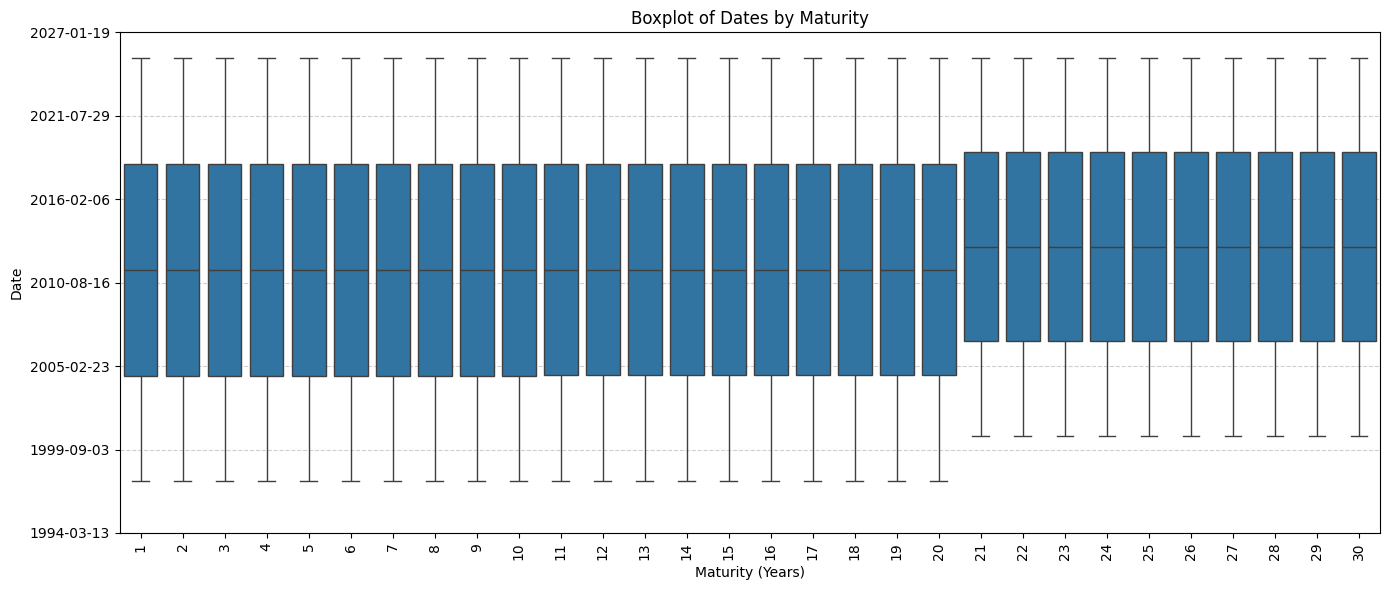

In [25]:
print("#-------------------------------------   OUTLIER ANALYSIS - Date Column -------------------------------------#")

# Prepare long-format date data for seaborn boxplot
date_long_df = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else None

    for date in df["Date"].dropna():
        date_long_df.append({"Maturity": maturity, "Date": date})

# Create DataFrame
df_plot_date = pd.DataFrame(date_long_df)

# Convert datetime to ordinal for boxplot
df_plot_date["DateOrdinal"] = df_plot_date["Date"].map(pd.Timestamp.toordinal)

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot_date, x="Maturity", y="DateOrdinal", showfliers=False)
plt.title("Boxplot of Dates by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Date")
plt.xticks(rotation=90)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

# Format y-axis back from ordinal to readable dates
locs, labels = plt.yticks()
plt.yticks(ticks=locs, labels=[pd.Timestamp.fromordinal(int(d)).strftime('%Y-%m-%d') for d in locs])

plt.tight_layout()
plt.show()


#### **Interest Rate Column**

-------------------------------------- OUTLIER ANALYSIS: INTEREST RATE ---------------------------------------


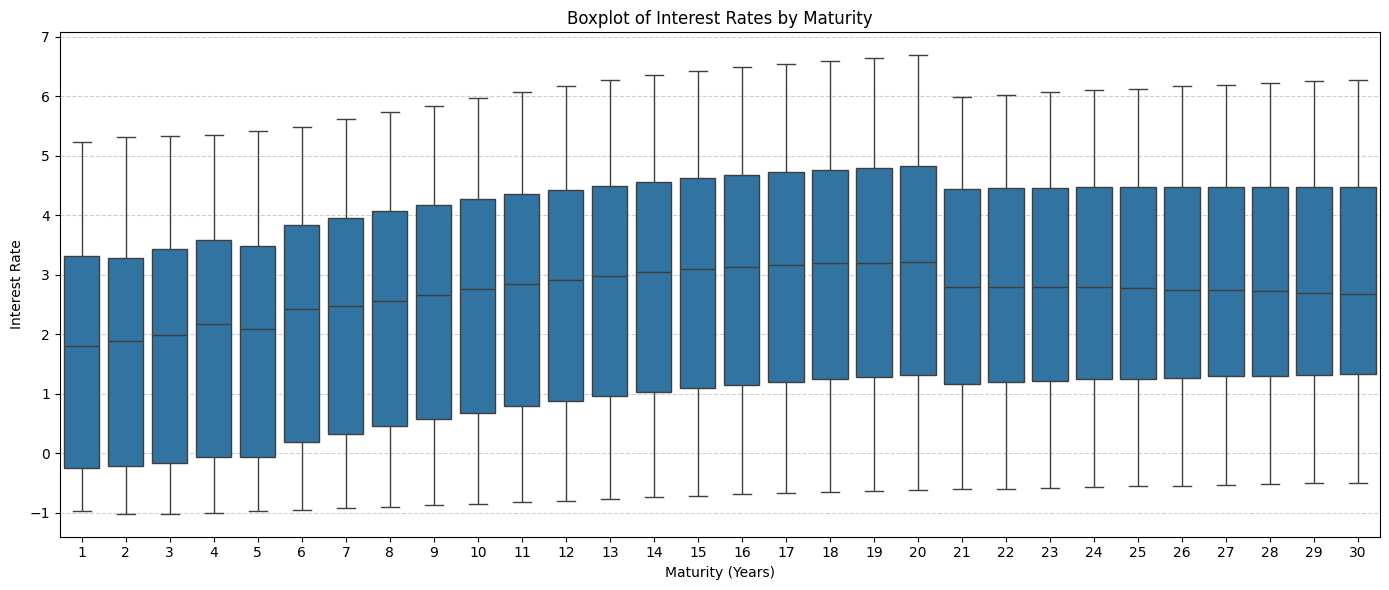

<ipython-input-23-c09835c2c4d9>:71: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




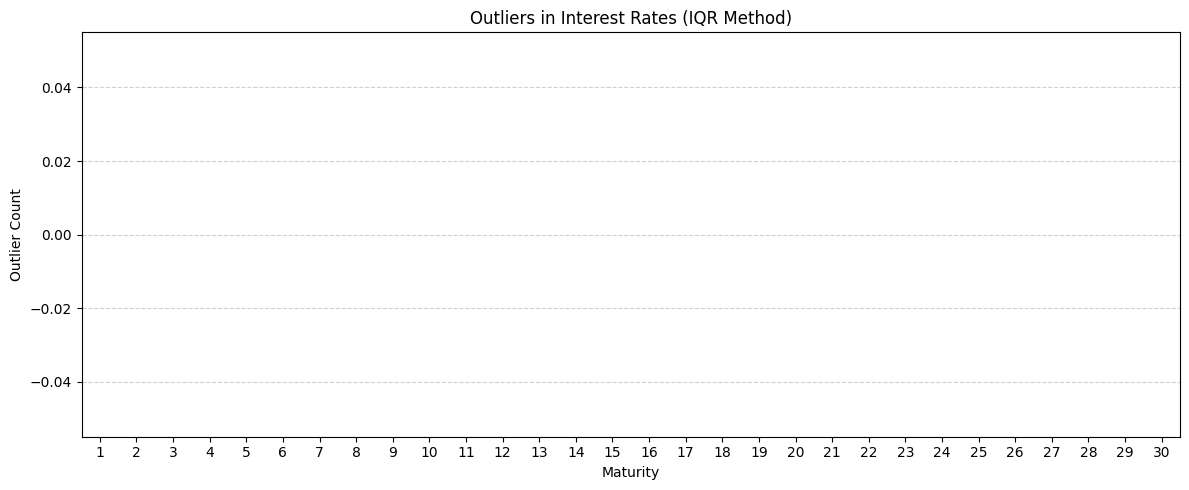

In [23]:
print("-------------------------------------- OUTLIER ANALYSIS - Interest Rate Column ---------------------------------------")

# Collect interest rate data
ir_long_df = []

outlier_counts_iqr = {}
outlier_counts_z = {}

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else None

    series = df["Interest Rate"].dropna()
    if len(series) < 10:
        continue

    # Append to long-format DataFrame list
    ir_long_df.extend([{"Maturity": maturity, "Interest Rate": val} for val in series])

    # IQR outliers
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_iqr = series[(series < lower) | (series > upper)]
    outlier_counts_iqr[maturity] = len(outliers_iqr)

    # Z-score outliers
    z_scores = zscore(series)
    outliers_z = series[(z_scores > 3) | (z_scores < -3)]
    outlier_counts_z[maturity] = len(outliers_z)

# Convert long-format data
df_plot_ir = pd.DataFrame(ir_long_df)

# Create boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot_ir, x="Maturity", y="Interest Rate", showfliers=True)
plt.title("Boxplot of Interest Rates by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Interest Rate")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Summary table using plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=["Maturity", "Total Outliers (IQR)", "Total Outliers (Z-Score)"],
                fill_color='paleturquoise', align='left'),
    cells=dict(values=[
        list(outlier_counts_iqr.keys()),
        list(outlier_counts_iqr.values()),
        [outlier_counts_z.get(k, 0) for k in outlier_counts_iqr.keys()]
    ],
               fill_color='lavender', align='left'))
])
fig.update_layout(title_text="Interest Rate Outlier Summary (IQR & Z-Score)")
fig.show()

# Histogram of IQR outliers
plt.figure(figsize=(12, 5))
sns.barplot(x=list(outlier_counts_iqr.keys()), y=list(outlier_counts_iqr.values()), palette="coolwarm")
plt.title("Outliers in Interest Rates (IQR Method)")
plt.xlabel("Maturity")
plt.ylabel("Outlier Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### **<font color='#474747'>*1.2.3 - Data Quality Checks*</font>**

In [27]:
print("----------------------------------------- DATA QUALITY CHECKS - per File  ---------------------------------------")

quality_checks = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    maturity_match = re.search(r"R(\d+)X", file_name)
    maturity = int(maturity_match.group(1)) if maturity_match else file_name

    # Basic checks
    is_sorted = df["Date"].is_monotonic_increasing
    duplicate_rows = df.duplicated().sum()
    duplicate_dates = df["Date"].duplicated().sum()
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()

    # Negative or zero interest rate values
    ir_col = "Interest Rate"
    if ir_col in df.columns:
        negative_or_zero = (df[ir_col] <= 0).sum()
    else:
        negative_or_zero = None

    quality_checks.append({
        "Maturity": maturity,
        "File Name": file_name,
        "Dates Sorted?": is_sorted,
        "Duplicate Rows": duplicate_rows,
        "Duplicate Dates": duplicate_dates,
        "Missing Values (Total)": total_missing,
        "Missing in 'Date'": missing_counts.get("Date", 0),
        "Missing in 'Interest Rate'": missing_counts.get("Interest Rate", 0),
        "Negative/Zero Interest Rates": negative_or_zero
    })

# Create DataFrame
quality_df = pd.DataFrame(quality_checks)
quality_df.set_index("Maturity", inplace=True)
quality_df.sort_index(inplace=True)

# Display summary
display(quality_df)

print("\n**Data Quality Check Complete!**\n")


----------------------------------------- DATA QUALITY CHECKS PER FILE ---------------------------------------


File Name  Dates Sorted?  \
Maturity                                                                     
1         daily-term-structure-spot-interest-rate-R01XX.csv           True   
2         daily-term-structure-spot-interest-rate-R02XX.csv           True   
3         daily-term-structure-spot-interest-rate-R03XX.csv           True   
4         daily-term-structure-spot-interest-rate-R04XX.csv           True   
5         daily-term-structure-spot-interest-rate-R005X.csv           True   
5         daily-term-structure-spot-interest-rate-R05XX.csv           True   
6         daily-term-structure-spot-interest-rate-R06XX.csv           True   
7         daily-term-structure-spot-interest-rate-R07XX.csv           True   
8         daily-term-structure-spot-interest-rate-R08XX.csv           True   
9         daily-term-structure-spot-interest-rate-R09XX.csv           True   
10        daily-term-structure-spot-interest-rate-R10XX.csv           True   
11        daily-term-structure-spot-interest-rate-R11XX.csv           True   
12        daily-term-structure-spot-interest-rate-R12XX.csv           True   
13        daily-term-structure-spot-interest-rate-R13XX.csv           True   
14        daily-term-structure-spot-interest-rate-R14XX.csv           True   
15        daily-term-structure-spot-interest-rate-R15XX.csv           True   
16        daily-term-structure-spot-interest-rate-R16XX.csv           True   
17        daily-term-structure-spot-interest-rate-R17XX.csv           True   
18        daily-term-structure-spot-interest-rate-R18XX.csv           True   
19        daily-term-structure-spot-interest-rate-R19XX.csv           True   
20        daily-term-structure-spot-interest-rate-R20XX.csv           True   
21        daily-term-structure-spot-interest-rate-R21XX.csv           True   
22        daily-term-structure-spot-interest-rate-R22XX.csv           True   
23        daily-term-structure-spot-interest-rate-R23XX.csv           True   
24        daily-term-structure-spot-interest-rate-R24XX.csv           True   
25        daily-term-structure-spot-interest-rate-R25XX.csv           True   
26        daily-term-structure-spot-interest-rate-R26XX.csv           True   
27        daily-term-structure-spot-interest-rate-R27XX.csv           True   
28        daily-term-structure-spot-interest-rate-R28XX.csv           True   
29        daily-term-structure-spot-interest-rate-R29XX.csv           True   
30        daily-term-structure-spot-interest-rate-R30XX.csv           True   

          Duplicate Rows  Duplicate Dates  Missing Values (Total)  \
Maturity                                                            
1                      0                0                   10150   
2                      0                0                   10150   
3                      0                0                   10150   
4                      0                0                   10150   
5                      0                0                   10150   
5                      0                0                   10150   
6                      0                0                   10150   
7                      0                0                   10150   
8                      0                0                   10150   
9                      0                0                   10150   
10                     0                0                   10150   
11                     0                0                   10149   
12                     0                0                   10149   
13                     0                0                   10149   
14                     0                0                   10149   
15                     0                0                   10149   
16                     0                0                   10149   
17                     0                0                   10149   
18                     0                0                   10149   
19                     0  


**Data Quality Check Complete!**



### **<font color='#474747'>*1.2.4 - Missing Values Per day of Week*</font>**

In [31]:
print("#------------------------------   MISSING VALUES - Per Working Day and Weekend ---------------#")
from collections import defaultdict
import pandas as pd
import re
from IPython.display import display

# Dictionaries to hold results
counts = []
percentages = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else file_name

    # Filter valid date rows and create weekday column
    df = df[df["Date"].notnull()].copy()
    df["Weekday"] = df["Date"].dt.strftime("%A")

    # Count total per weekday
    total_counts = df["Weekday"].value_counts()

    # Count missing interest rates per weekday
    missing_counts = df[df["Interest Rate"].isnull()]["Weekday"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
        total = total_counts.get(day, 0)
        missing = missing_counts.get(day, 0)
        row_counts[day] = missing
        row_percentages[day] = round((missing / total * 100), 2) if total > 0 else None

    counts.append(row_counts)
    percentages.append(row_percentages)

# Convert to DataFrames
missing_counts_df = pd.DataFrame(counts).set_index("Maturity").sort_index()
missing_percent_df = pd.DataFrame(percentages).set_index("Maturity").sort_index()

# Display both
print("Missing Interest Rate Counts by Weekday:")
display(missing_counts_df)

print("Percentage Missing Interest Rates by Weekday:")
display(missing_percent_df)



#------------------------------   MISSING VALUES PER WORKING DAY AND WEEKEND ---------------#
Missing Interest Rate Counts by Weekday:


Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Maturity                                                                
1             64       28         26        29      55      1450    1450
2             64       28         26        29      55      1450    1450
3             64       28         26        29      55      1450    1450
4             64       28         26        29      55      1450    1450
5             64       28         26        29      55      1450    1450
5             64       28         26        29      55      1450    1450
6             64       28         26        29      55      1450    1450
7             64       28         26        29      55      1450    1450
8             64       28         26        29      55      1450    1450
9             64       28         26        29      55      1450    1450
10            64       28         26        29      55      1450    1450
11            64       28         26        29      54      1450    1450
12            64       28         26        29      54      1450    1450
13            64       28         26        29      54      1450    1450
14            64       28         26        29      54      1450    1450
15            64       28         26        29      54      1450    1450
16            64       28         26        29      54      1450    1450
17            64       28         26        29      54      1450    1450
18            64       28         26        29      54      1450    1450
19            64       28         26        29      54      1450    1450
20            64       28         26        29      54      1450    1450
21            57       27         23        21      44      1293    1293
22            57       27         23        21      44      1293    1293
23            57       27         23        21      44      1293    1293
24            57       27         23        21      44      1293    1293
25            57       27         23        21      44      1293    1293
26            57       27         23        21      44      1293    1293
27            57       27         23        21      44      1293    1293
28            57       27         23        21      44      1293    1293
29            57       27         23        21      44      1293    1293
30            57       27         23        21      44      1293    1293

Percentage Missing Interest Rates by Weekday:


Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Maturity                                                                
1           4.41     1.93       1.79      2.00    3.79     100.0   100.0
2           4.41     1.93       1.79      2.00    3.79     100.0   100.0
3           4.41     1.93       1.79      2.00    3.79     100.0   100.0
4           4.41     1.93       1.79      2.00    3.79     100.0   100.0
5           4.41     1.93       1.79      2.00    3.79     100.0   100.0
5           4.41     1.93       1.79      2.00    3.79     100.0   100.0
6           4.41     1.93       1.79      2.00    3.79     100.0   100.0
7           4.41     1.93       1.79      2.00    3.79     100.0   100.0
8           4.41     1.93       1.79      2.00    3.79     100.0   100.0
9           4.41     1.93       1.79      2.00    3.79     100.0   100.0
10          4.41     1.93       1.79      2.00    3.79     100.0   100.0
11          4.41     1.93       1.79      2.00    3.73     100.0   100.0
12          4.41     1.93       1.79      2.00    3.73     100.0   100.0
13          4.41     1.93       1.79      2.00    3.73     100.0   100.0
14          4.41     1.93       1.79      2.00    3.73     100.0   100.0
15          4.41     1.93       1.79      2.00    3.73     100.0   100.0
16          4.41     1.93       1.79      2.00    3.73     100.0   100.0
17          4.41     1.93       1.79      2.00    3.73     100.0   100.0
18          4.41     1.93       1.79      2.00    3.73     100.0   100.0
19          4.41     1.93       1.79      2.00    3.73     100.0   100.0
20          4.41     1.93       1.79      2.00    3.73     100.0   100.0
21          4.41     2.09       1.78      1.62    3.40     100.0   100.0
22          4.41     2.09       1.78      1.62    3.40     100.0   100.0
23          4.41     2.09       1.78      1.62    3.40     100.0   100.0
24          4.41     2.09       1.78      1.62    3.40     100.0   100.0
25          4.41     2.09       1.78      1.62    3.40     100.0   100.0
26          4.41     2.09       1.78      1.62    3.40     100.0   100.0
27          4.41     2.09       1.78      1.62    3.40     100.0   100.0
28          4.41     2.09       1.78      1.62    3.40     100.0   100.0
29          4.41     2.09       1.78      1.62    3.40     100.0   100.0
30          4.41     2.09       1.78      1.62    3.40     100.0   100.0

##### 1.2.4.1 - Heatmap Missing Values

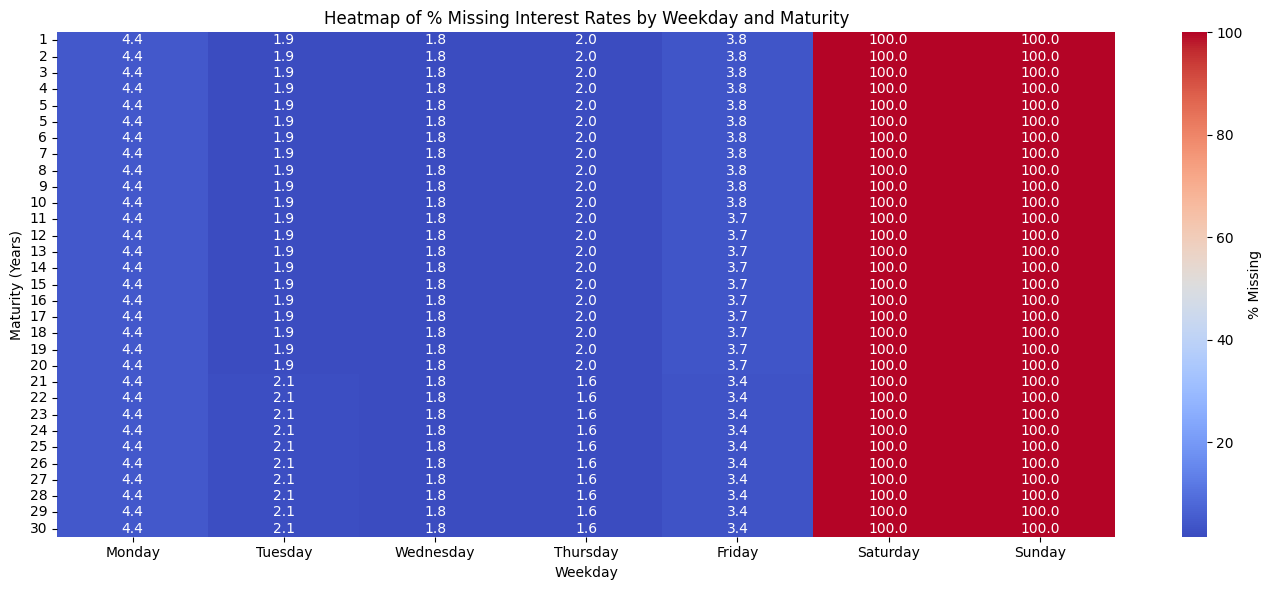

In [32]:
print("#------------------------------   HEATMAP MISSING VALUES - Per Work Day and Weekend  ---------------#")
# Reorder weekday columns for better readability
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = missing_percent_df[weekday_order]

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Weekday and Maturity")
plt.xlabel("Weekday")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

* Saturday & Sunday are always 100% missing
→ No rates published on weekends (normal).

* Weekday missingness is low (mostly ~1.6–4.4%)
→ These are likely holidays, system outages, or publication lags.





## **<font color='#474747'>1.2 - Data Cleaning** - check

### **<font color='#474747'>*1.3.1 - Apply Data Cleaning*</font>**
* Remove weekends completely
*  Forward-fill missing values (only on weekdays)
* Interpoalte remaning gaps because for yield curve modeling (e.g., Nelson-Siegel) - continuity is needed.

In [41]:
print("#-------------------------------------   DATA CLEANING - Apply Filling -------------------------------------#")
for i, df in enumerate(dataframes):
    # Step 1: Remove weekends (keep only Mon-Fri)
    df = df.dropna(subset=["Date"]).copy()
    df = df[~df["Date"].dt.weekday.isin([5, 6])].copy()

    # Step 2: Forward-fill up to 2 days
    df["Interest Rate"] = df["Interest Rate"].ffill(limit=3)

    # Step 3: Backward-fill up to 2 days
    df["Interest Rate"] = df["Interest Rate"].bfill(limit=3)

    # Step 4: Interpolate remaining gaps
    df["Interest Rate"] = df["Interest Rate"].interpolate(method="linear")

    # Update cleaned DataFrame back in the list
    dataframes[i] = df



### **<font color='#474747'>*1.3.2 - Heatmap Missing Values*</font>**

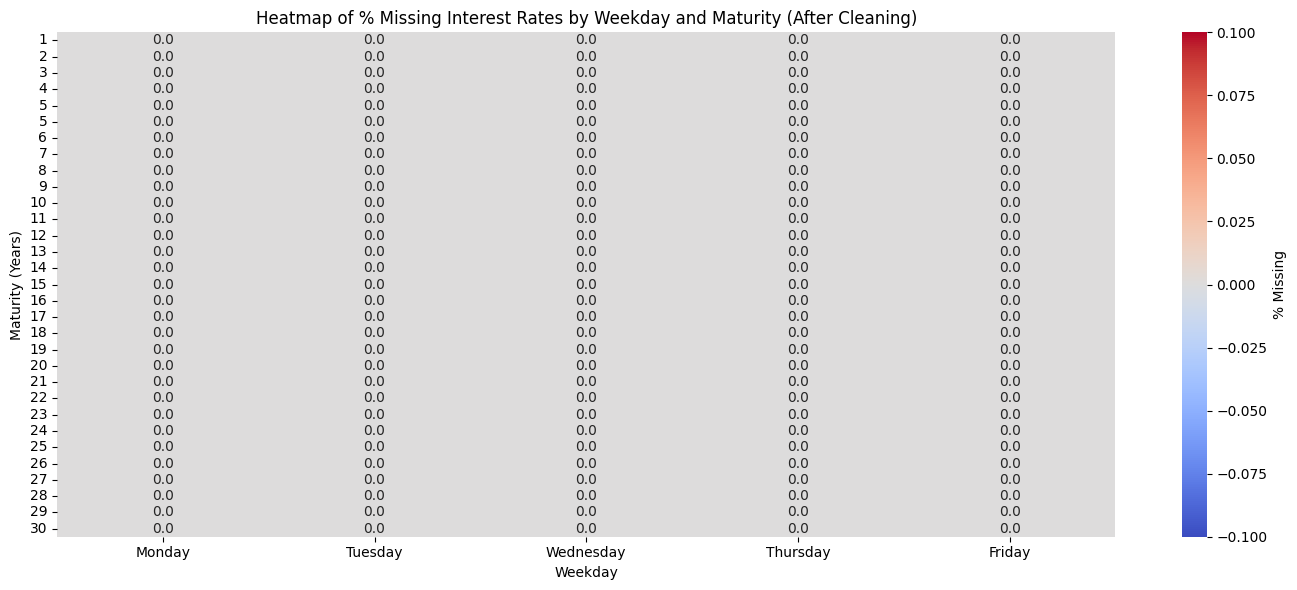

In [42]:
print("#-------------------------------------   DATA CLEANING - Heatmap Check On Misisng Data -------------------------------------#")
# Recompute missing values by weekday after cleaning
counts = []
percentages = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else file_name

    # Ensure date is valid and weekday column is available
    df = df[df["Date"].notnull()].copy()
    df["Weekday"] = df["Date"].dt.strftime("%A")

    # Drop Saturday and Sunday (already excluded but kept as safeguard)
    df = df[~df["Weekday"].isin(["Saturday", "Sunday"])]

    # Count total per weekday
    total_counts = df["Weekday"].value_counts()

    # Count missing interest rates per weekday
    missing_counts = df[df["Interest Rate"].isnull()]["Weekday"].value_counts()

    row_percentages = {"Maturity": maturity}
    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        total = total_counts.get(day, 0)
        missing = missing_counts.get(day, 0)
        row_percentages[day] = round((missing / total * 100), 2) if total > 0 else 0

    percentages.append(row_percentages)

# Create DataFrame
missing_percent_cleaned_df = pd.DataFrame(percentages).set_index("Maturity").sort_index()

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(missing_percent_cleaned_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Weekday and Maturity (After Cleaning)")
plt.xlabel("Weekday")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Next steps:

2. Data exploration: For each DataFrame, explore the data to understand its structure, including the number of rows and columns, data types of each column, descriptive statistics (mean, median, standard deviation, min, max) for numerical columns, and the presence of missing values. Also check for the date range covered in each file.

3. Data analysis: Analyze the relationships between different interest rates within each dataset and across datasets. Calculate correlations between different maturity rates. Look for trends and patterns in interest rate movements over time.

4. Data visualization: Create visualizations to represent the key findings. Visualize the time series of interest rates for different maturities. Show the correlation matrix between interest rates. Visualize any significant trends or patterns.

5. Finish task: Summarize the key characteristics of each dataset, highlighting any commonalities or differences across datasets. Present findings from the data exploration and analysis sections in a clear and concise manner, including the visualizations.

In [134]:
import numpy as np

# Store cleaned data and statistics
cleaned_dataframes = []
statistics = []

for i, df in enumerate(dataframes):
    # Step 1: Skip the first 10 rows
    df = df.iloc[10:].copy()  # start from row 11 (index 10)

    # Step 2: Reset index and rename columns
    df.reset_index(drop=True, inplace=True)
    df.columns = ['Date', 'InterestRate', 'Comment']

    # Step 3: Clean interest rate values
    df['InterestRate'] = df['InterestRate'].replace('.', np.nan)
    df['InterestRate'] = pd.to_numeric(df['InterestRate'], errors='coerce')

    # Step 4: Parse the date column
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Step 5: Drop NaN interest rate rows for stats
    df_clean = df.dropna(subset=['InterestRate'])

    # Step 6: Calculate stats
    stats = {
        'File': csv_files[i],
        'Count': df_clean['InterestRate'].count(),
        'Mean': df_clean['InterestRate'].mean(),
        'Median': df_clean['InterestRate'].median(),
        'Std': df_clean['InterestRate'].std(),
        'Min': df_clean['InterestRate'].min(),
        'Max': df_clean['InterestRate'].max()
    }

    # Store results
    cleaned_dataframes.append(df_clean)
    statistics.append(stats)

# Combine stats into a DataFrame
stats_df = pd.DataFrame(statistics)

# Display the stats summary
from IPython.display import display
display(stats_df)


ValueError: Length mismatch: Expected axis has 5 elements, new values have 3 elements

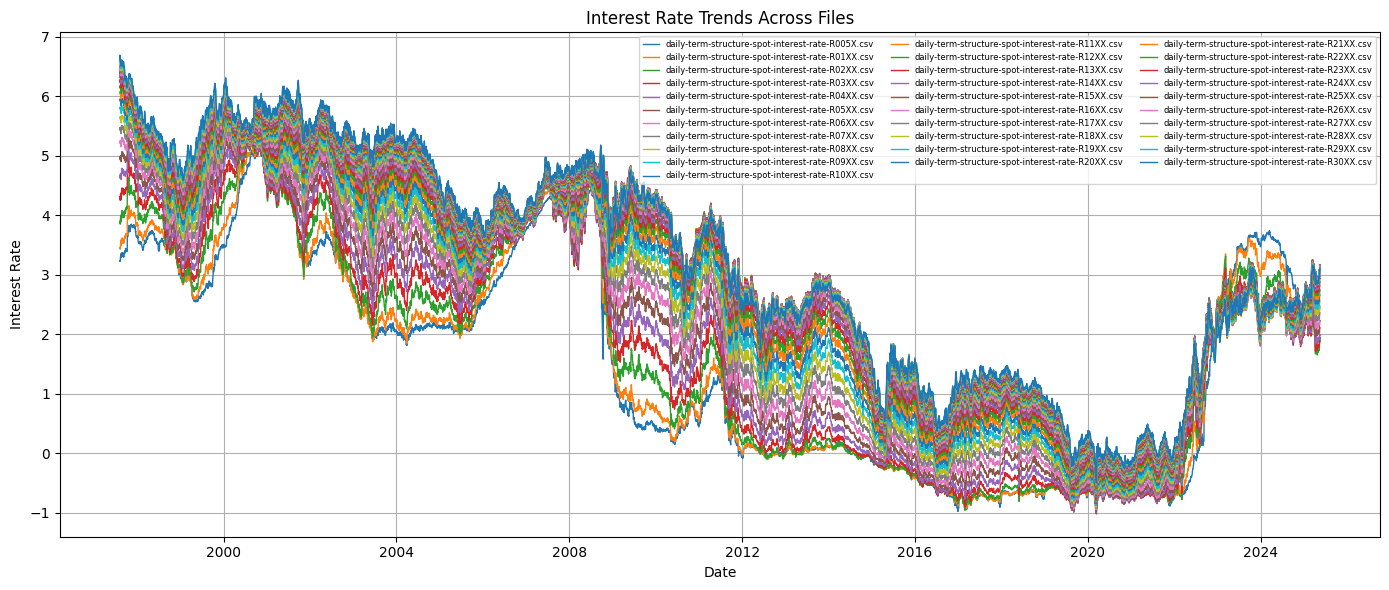

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for i, df in enumerate(cleaned_dataframes):
    plt.plot(df['Date'], df['InterestRate'], label=csv_files[i], linewidth=1)

plt.title('Interest Rate Trends Across Files')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend(loc='upper right', fontsize=6, ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()


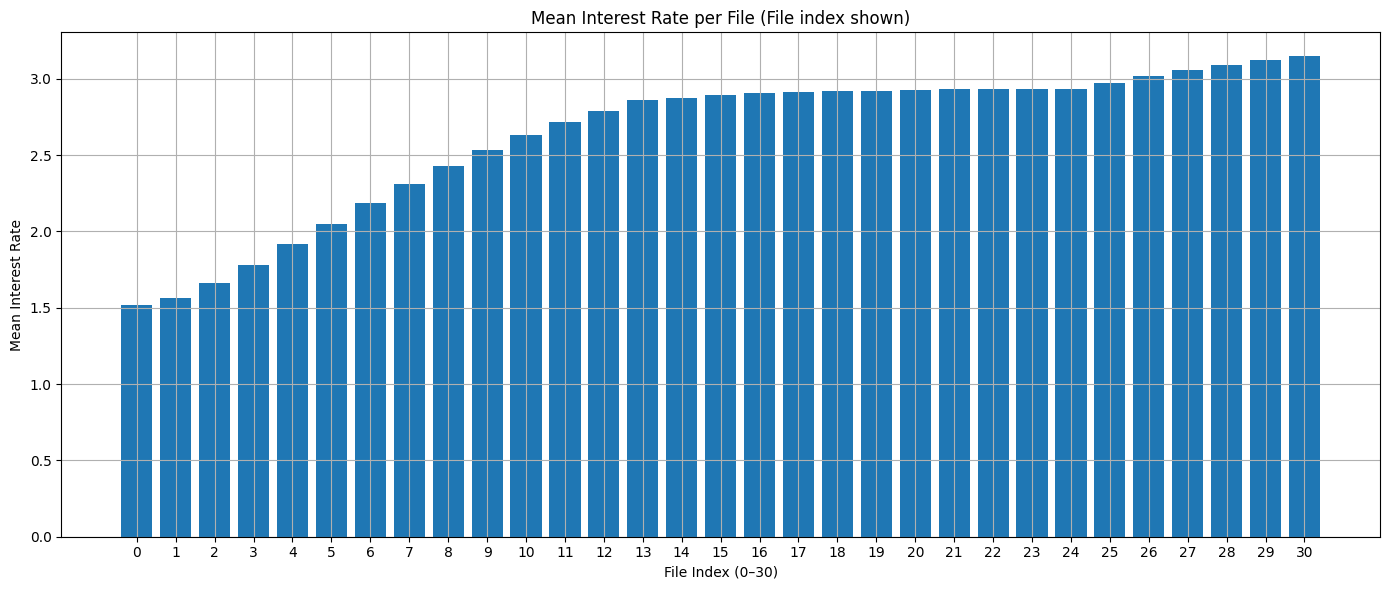

0: daily-term-structure-spot-interest-rate-R005X.csv
1: daily-term-structure-spot-interest-rate-R01XX.csv
2: daily-term-structure-spot-interest-rate-R02XX.csv
3: daily-term-structure-spot-interest-rate-R03XX.csv
4: daily-term-structure-spot-interest-rate-R04XX.csv
5: daily-term-structure-spot-interest-rate-R05XX.csv
6: daily-term-structure-spot-interest-rate-R06XX.csv
7: daily-term-structure-spot-interest-rate-R07XX.csv
8: daily-term-structure-spot-interest-rate-R08XX.csv
9: daily-term-structure-spot-interest-rate-R09XX.csv
10: daily-term-structure-spot-interest-rate-R10XX.csv
11: daily-term-structure-spot-interest-rate-R11XX.csv
12: daily-term-structure-spot-interest-rate-R12XX.csv
13: daily-term-structure-spot-interest-rate-R13XX.csv
14: daily-term-structure-spot-interest-rate-R21XX.csv
15: daily-term-structure-spot-interest-rate-R22XX.csv
16: daily-term-structure-spot-interest-rate-R23XX.csv
17: daily-term-structure-spot-interest-rate-R24XX.csv
18: daily-term-structure-spot-interest

In [ ]:
# Add index numbers for x-axis
stats_df_sorted = stats_df_sorted.reset_index(drop=True)
plt.figure(figsize=(14, 6))
plt.bar(stats_df_sorted.index, stats_df_sorted['Mean'])

# Label the x-axis with index instead of full filenames
plt.xticks(stats_df_sorted.index, stats_df_sorted.index)
plt.title('Mean Interest Rate per File (File index shown)')
plt.xlabel('File Index (0–30)')
plt.ylabel('Mean Interest Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print index-to-filename map
for i, file in enumerate(stats_df_sorted['File']):
    print(f"{i}: {file}")


In [ ]:
summary = []

for i, df in enumerate(cleaned_dataframes):
    total_rows = len(df)
    valid = df['InterestRate'].notna().sum()
    missing = total_rows - valid
    missing_pct = (missing / total_rows) * 100

    start_date = df['Date'].min()
    end_date = df['Date'].max()
    duration_days = (end_date - start_date).days if pd.notnull(start_date) and pd.notnull(end_date) else None

    duplicate_dates = df['Date'].duplicated().sum()
    invalid_dates = df['Date'].isna().sum()

    summary.append({
        'File': csv_files[i],
        'Total Rows': total_rows,
        'Valid Entries': valid,
        'Missing (%)': round(missing_pct, 2),
        'Mean': df['InterestRate'].mean(),
        'Median': df['InterestRate'].median(),
        'Std': df['InterestRate'].std(),
        'Min': df['InterestRate'].min(),
        'Max': df['InterestRate'].max(),
        'Start Date': start_date,
        'End Date': end_date,
        'Date Coverage (days)': duration_days,
        'Duplicate Dates': duplicate_dates,
        'Invalid Dates (NaT)': invalid_dates,
    })

summary_df = pd.DataFrame(summary)

# Display the summary table
import seaborn as sns
from IPython.display import display
display(summary_df)


File  Total Rows  \
0   daily-term-structure-spot-interest-rate-R005X.csv        7048   
1   daily-term-structure-spot-interest-rate-R01XX.csv        7048   
2   daily-term-structure-spot-interest-rate-R02XX.csv        7048   
3   daily-term-structure-spot-interest-rate-R03XX.csv        7048   
4   daily-term-structure-spot-interest-rate-R04XX.csv        7048   
5   daily-term-structure-spot-interest-rate-R05XX.csv        7048   
6   daily-term-structure-spot-interest-rate-R06XX.csv        7048   
7   daily-term-structure-spot-interest-rate-R07XX.csv        7048   
8   daily-term-structure-spot-interest-rate-R08XX.csv        7048   
9   daily-term-structure-spot-interest-rate-R09XX.csv        7048   
10  daily-term-structure-spot-interest-rate-R10XX.csv        7048   
11  daily-term-structure-spot-interest-rate-R11XX.csv        7048   
12  daily-term-structure-spot-interest-rate-R12XX.csv        7048   
13  daily-term-structure-spot-interest-rate-R13XX.csv        7048   
14  daily-term-structure-spot-interest-rate-R14XX.csv        7048   
15  daily-term-structure-spot-interest-rate-R15XX.csv        7048   
16  daily-term-structure-spot-interest-rate-R16XX.csv        7048   
17  daily-term-structure-spot-interest-rate-R17XX.csv        7048   
18  daily-term-structure-spot-interest-rate-R18XX.csv        7048   
19  daily-term-structure-spot-interest-rate-R19XX.csv        7048   
20  daily-term-structure-spot-interest-rate-R20XX.csv        7048   
21  daily-term-structure-spot-interest-rate-R21XX.csv        6294   
22  daily-term-structure-spot-interest-rate-R22XX.csv        6294   
23  daily-term-structure-spot-interest-rate-R23XX.csv        6294   
24  daily-term-structure-spot-interest-rate-R24XX.csv        6294   
25  daily-term-structure-spot-interest-rate-R25XX.csv        6294   
26  daily-term-structure-spot-interest-rate-R26XX.csv        6294   
27  daily-term-structure-spot-interest-rate-R27XX.csv        6294   
28  daily-term-structure-spot-interest-rate-R28XX.csv        6294   
29  daily-term-structure-spot-interest-rate-R29XX.csv        6294   
30  daily-term-structure-spot-interest-rate-R30XX.csv        6294   

    Valid Entries  Missing (%)      Mean  Median       Std   Min   Max  \
0            7048          0.0  1.520241   1.655  1.833644 -0.98  5.12   
1            7048          0.0  1.564343   1.805  1.842042 -0.97  5.23   
2            7048          0.0  1.661152   1.890  1.863627 -1.02  5.32   
3            7048          0.0  1.781524   1.990  1.885157 -1.02  5.33   
4            7048          0.0  1.914735   2.170  1.900096 -1.00  5.35   
5            7048          0.0  2.051073   2.320  1.907814 -0.98  5.42   
6            7048          0.0  2.184051   2.430  1.909892 -0.95  5.48   
7            7048          0.0  2.309895   2.480  1.908469 -0.93  5.61   
8            7048          0.0  2.426436   2.550  1.905424 -0.91  5.73   
9            7048          0.0  2.532889   2.660  1.901973 -0.88  5.84   
10           7048          0.0  2.629012   2.760  1.898492 -0.85  5.97   
11           7048          0.0  2.715106   2.850  1.895801 -0.82  6.08   
12           7048          0.0  2.791820   2.910  1.893829 -0.80  6.18   
13           7048          0.0  2.859667   2.980  1.892588 -0.77  6.28   
14           7048          0.0  2.919421   3.040  1.892116 -0.74  6.36   
15           7048          0.0  2.971840   3.090  1.892460 -0.72  6.43   
16           7048          0.0  3.017618   3.130  1.893271 -0.69  6.50   
17           7048          0.0  3.057348   3.165  1.894763 -0.67  6.55   
18           7048          0.0  3.091735   3.190  1.896570 -0.65  6.60   
19           7048          0.0  3.121331   3.205  1.898811 -0.64  6.65   
20           7048          0.0  3.146633   3.220  1.901452 -0.62  6.69   
21           6294          0.0  2.876072   2.800  1.799510 -0.61  5.98   
22           6294          0.0  2.891972   2.800  1.800045 -0.60  6.03   
23           6294          0.0  2.904871   2.790  1.800721 -0.58

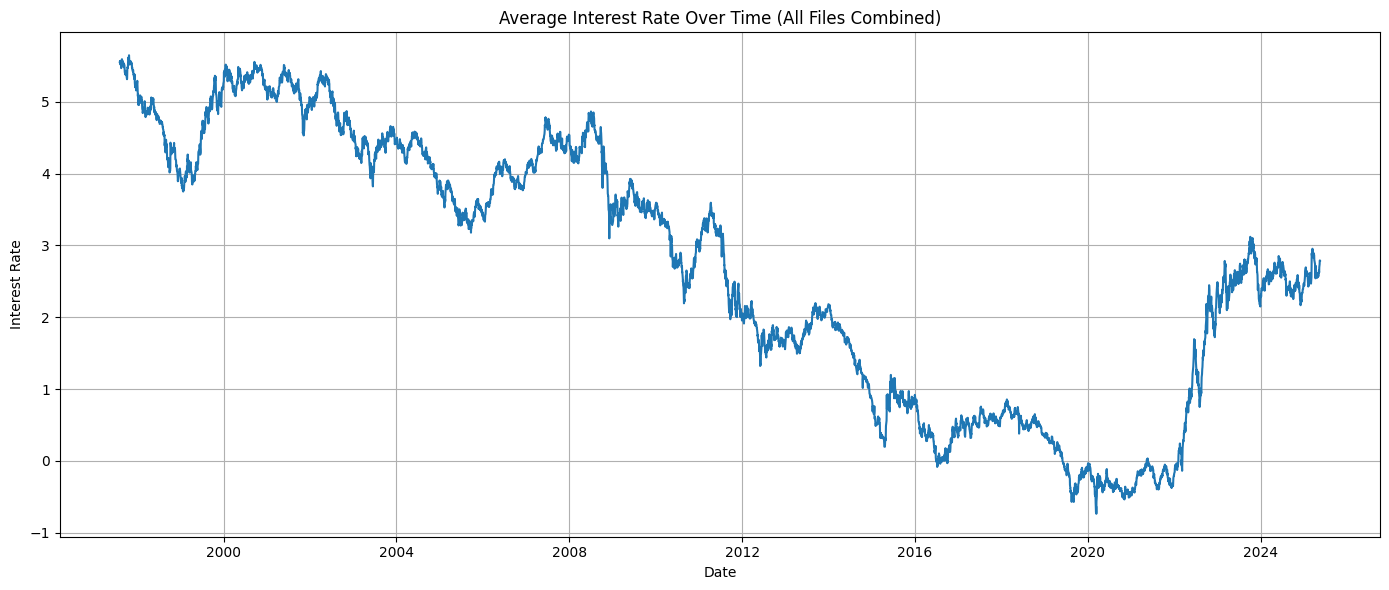

In [ ]:
# Combine all into one big DataFrame
combined_df = pd.concat(cleaned_dataframes, ignore_index=True)

# Group by date, calculate mean interest rate across files
daily_avg = combined_df.groupby('Date')['InterestRate'].mean().reset_index()

# Plot the aggregated trend
plt.figure(figsize=(14, 6))
plt.plot(daily_avg['Date'], daily_avg['InterestRate'], label='Average Interest Rate')
plt.title('Average Interest Rate Over Time (All Files Combined)')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

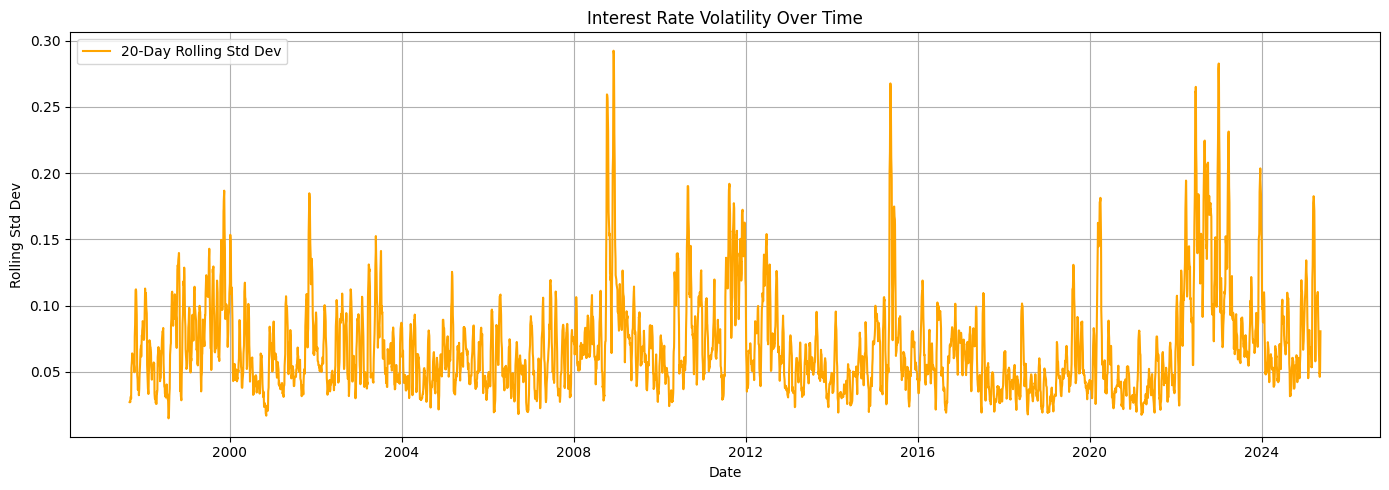

In [ ]:
# 20-day rolling standard deviation
daily_avg['RollingStd'] = daily_avg['InterestRate'].rolling(window=20).std()

plt.figure(figsize=(14, 5))
plt.plot(daily_avg['Date'], daily_avg['RollingStd'], color='orange', label='20-Day Rolling Std Dev')
plt.title('Interest Rate Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Std Dev')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

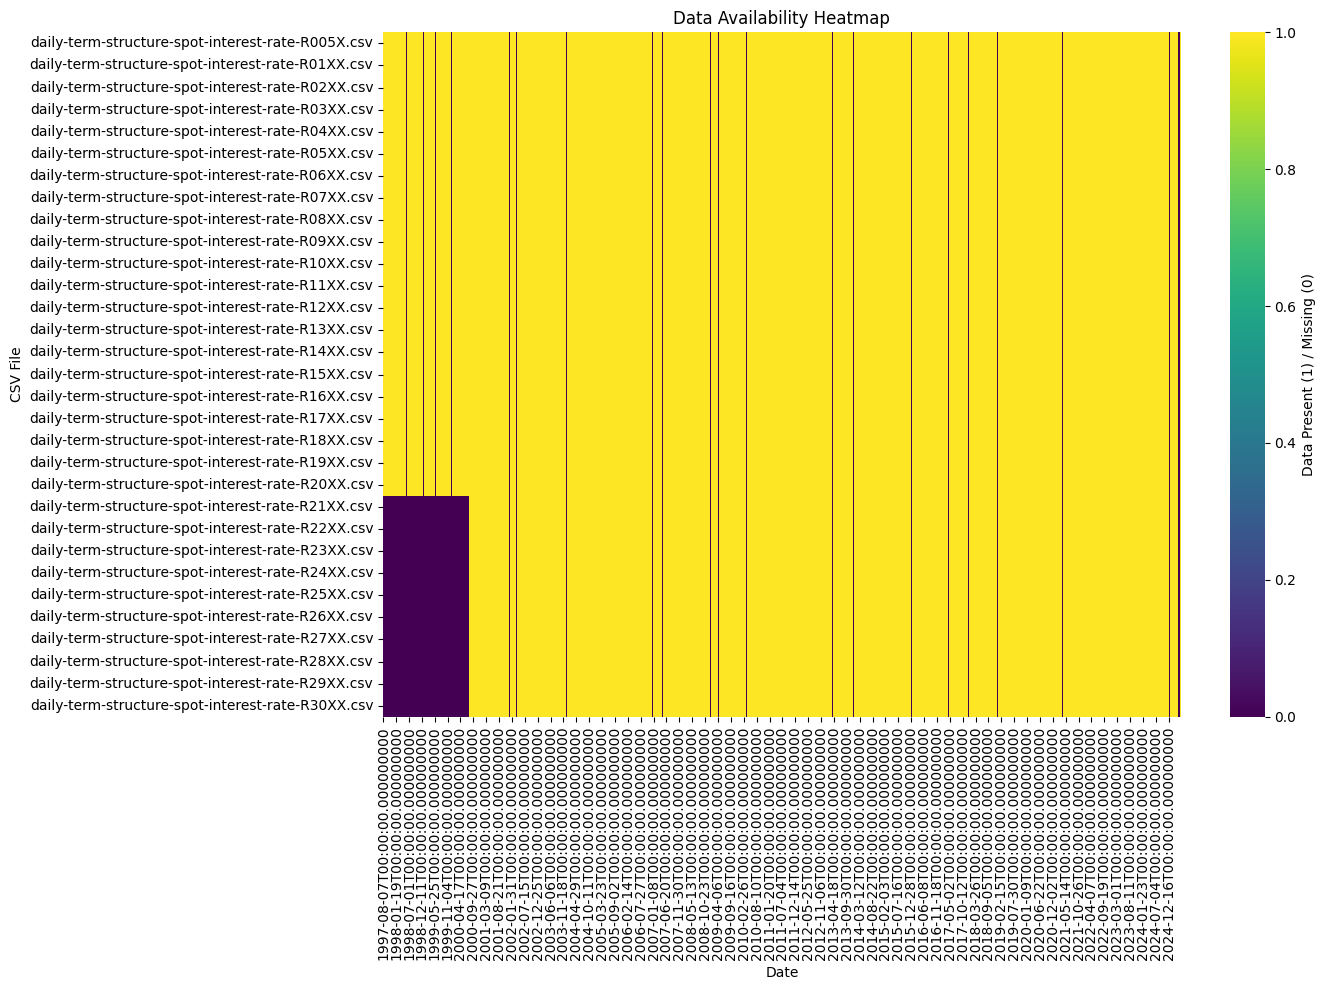

In [ ]:
# Create a matrix of Date vs File with 1 = present, 0 = missing
all_dates = pd.date_range(start=combined_df['Date'].min(), end=combined_df['Date'].max(), freq='B')
heatmap_df = pd.DataFrame(index=all_dates)

for i, df in enumerate(cleaned_dataframes):
    temp = df[['Date', 'InterestRate']].copy()
    temp['HasData'] = temp['InterestRate'].notna().astype(int)
    temp.set_index('Date', inplace=True)
    temp = temp.reindex(all_dates, fill_value=0)
    heatmap_df[csv_files[i]] = temp['HasData']

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_df.T, cmap='viridis', cbar_kws={'label': 'Data Present (1) / Missing (0)'})
plt.title('Data Availability Heatmap')
plt.xlabel('Date')
plt.ylabel('CSV File')
plt.tight_layout()
plt.show()

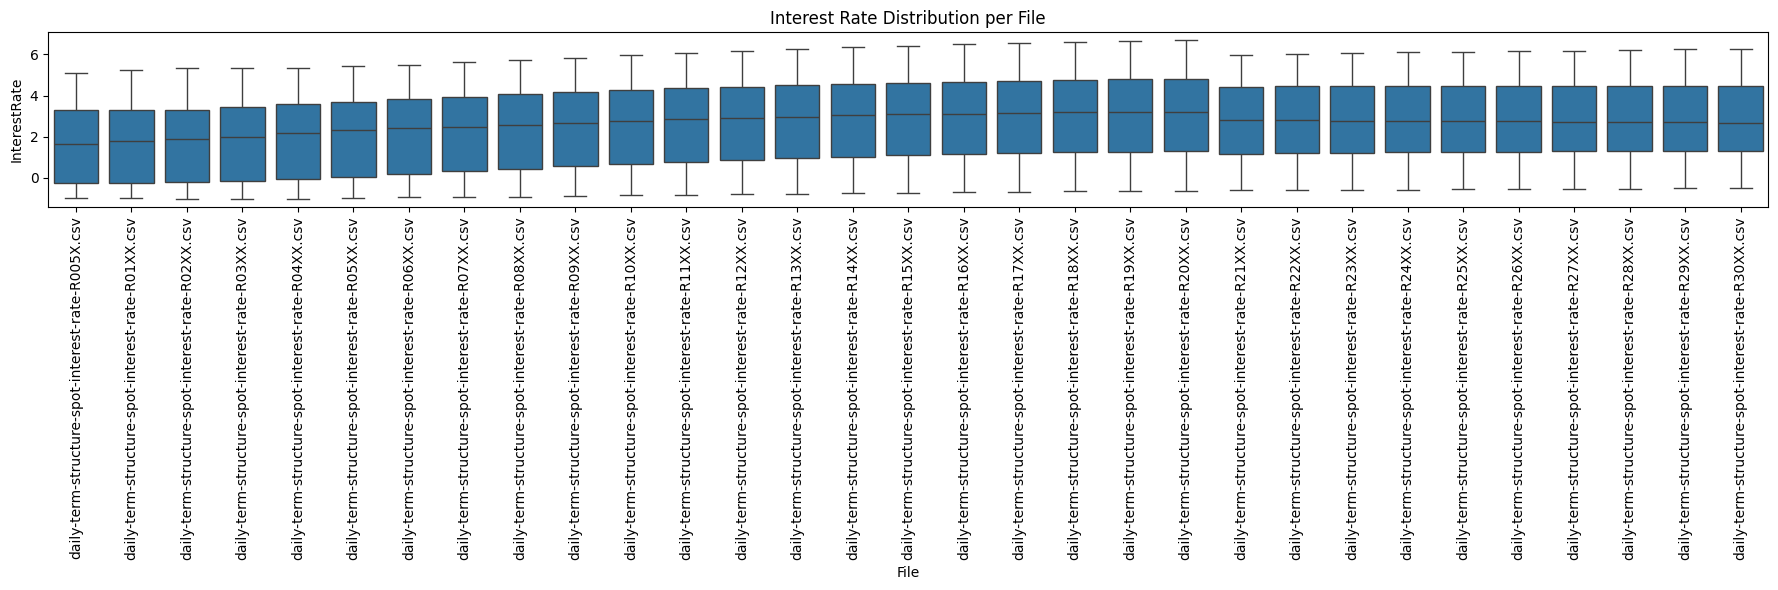

In [ ]:
# For boxplot, tag all records with file name
plot_data = []
for i, df in enumerate(cleaned_dataframes):
    df_temp = df[['InterestRate']].copy()
    df_temp['File'] = csv_files[i]
    plot_data.append(df_temp)

boxplot_df = pd.concat(plot_data)

# Plot
plt.figure(figsize=(18, 6))
sns.boxplot(data=boxplot_df, x='File', y='InterestRate')
plt.xticks(rotation=90)
plt.title('Interest Rate Distribution per File')
plt.tight_layout()
plt.show()

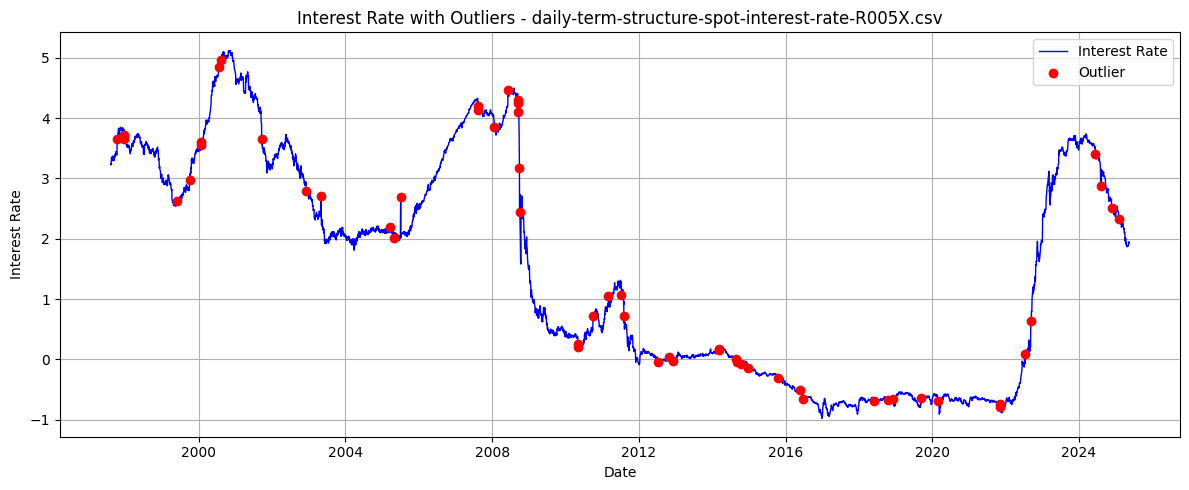

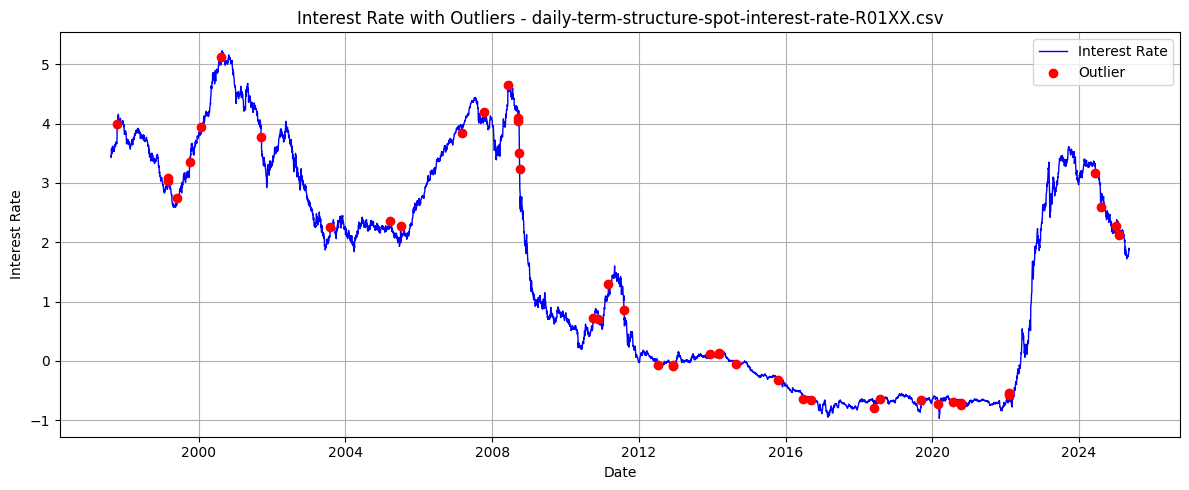

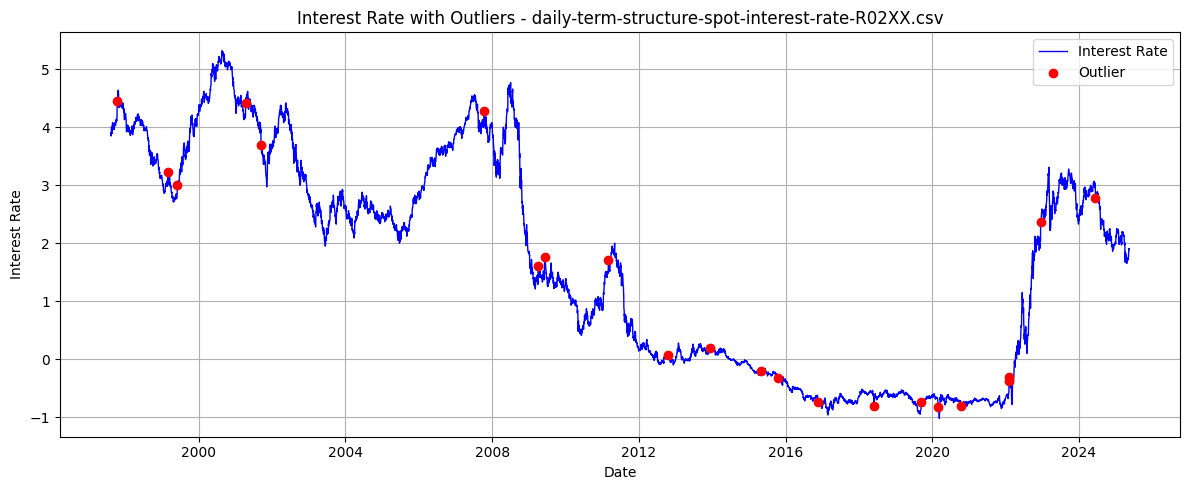

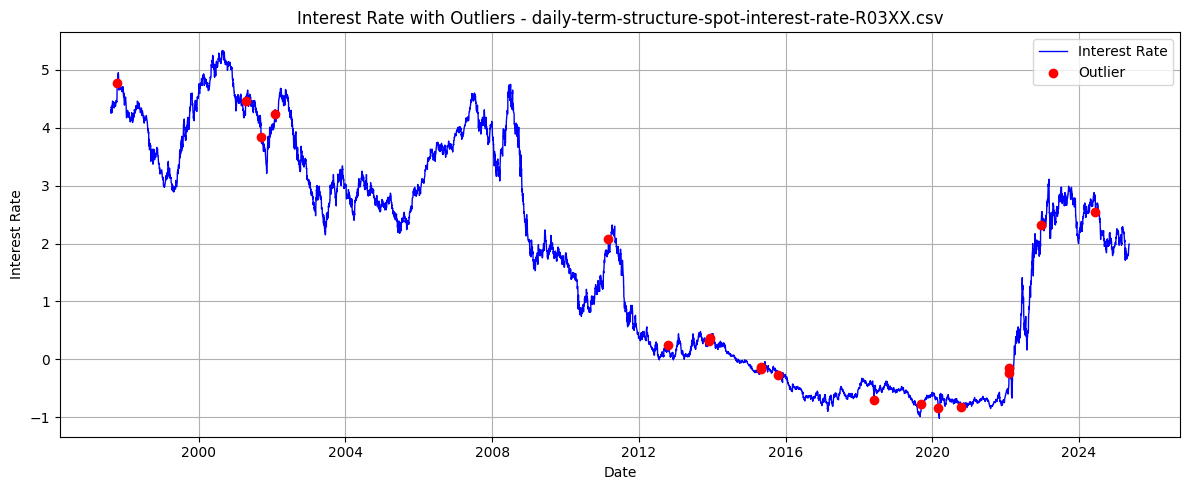

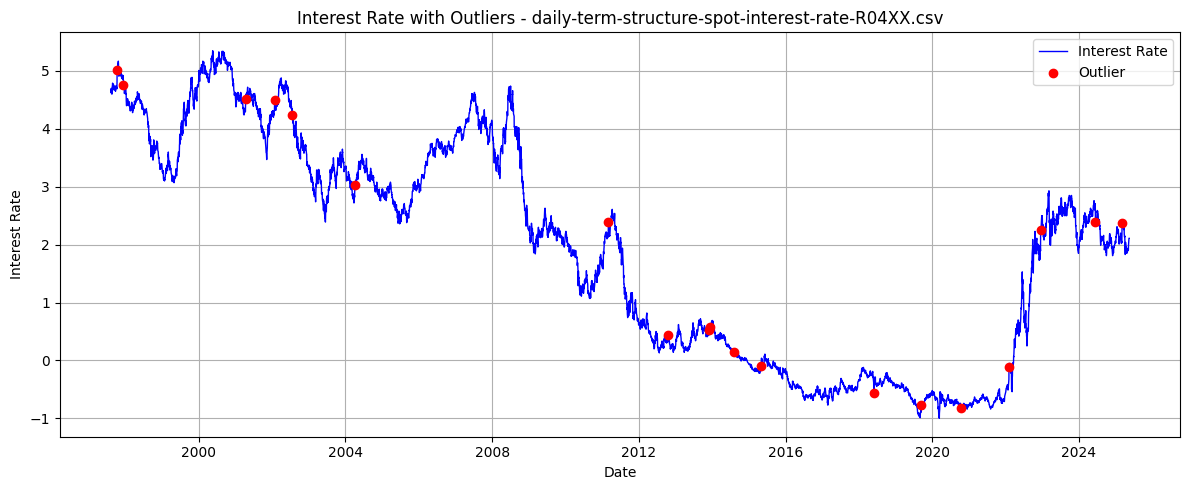

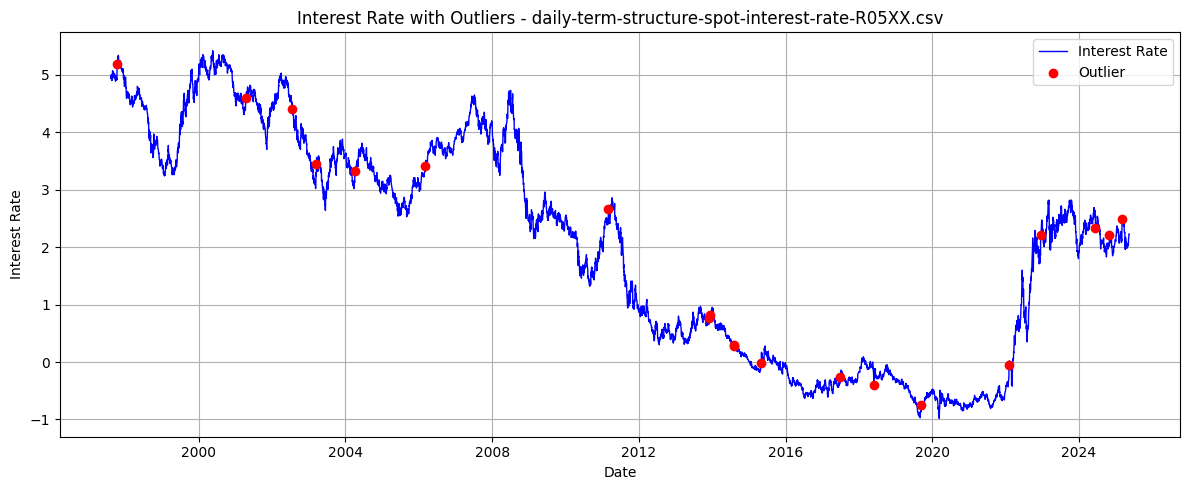

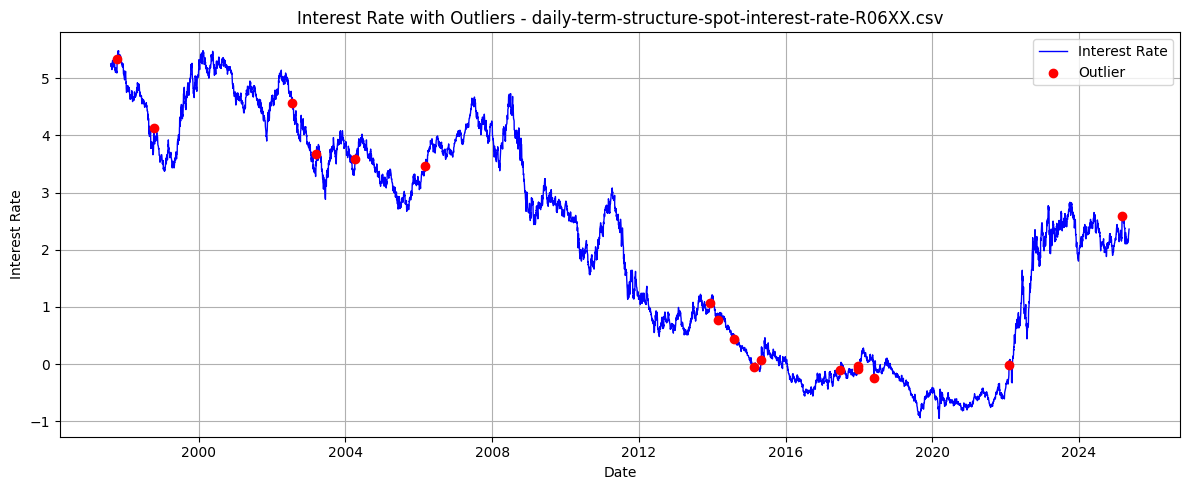

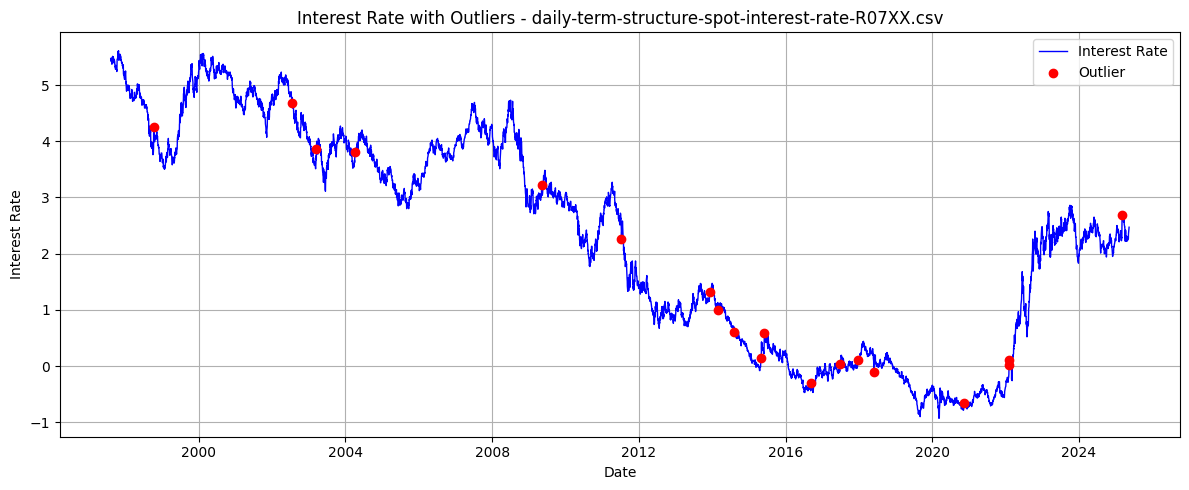

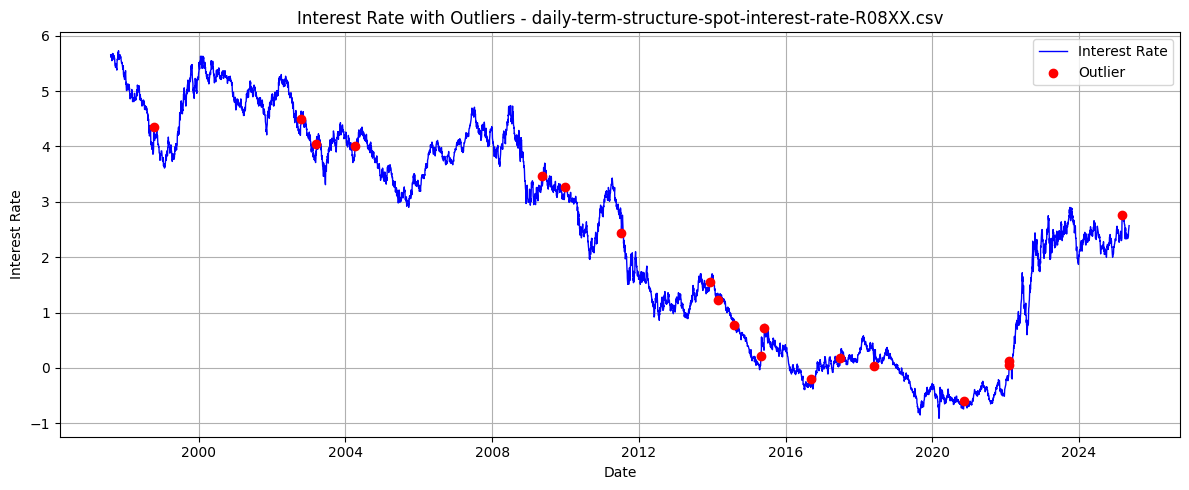

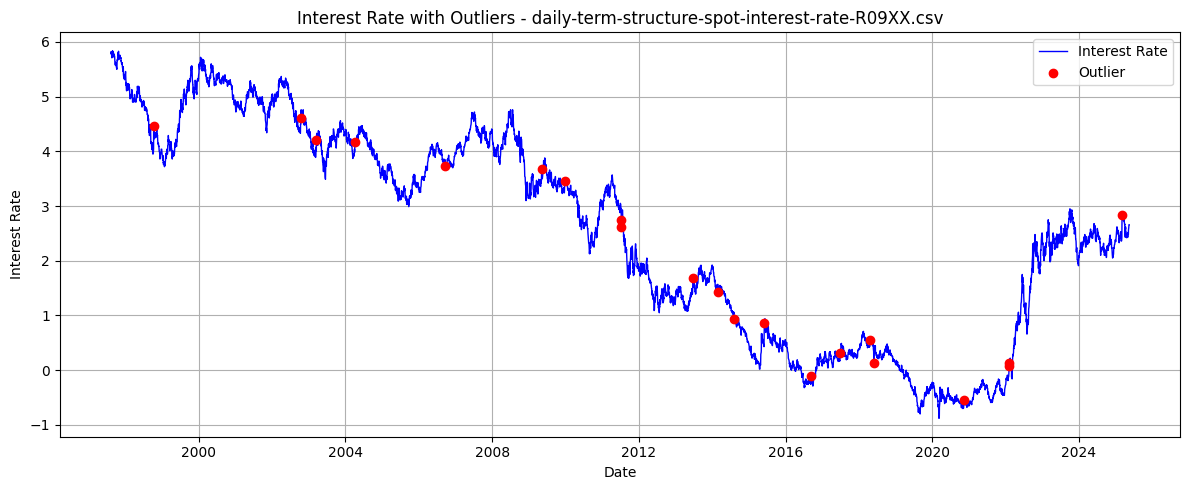

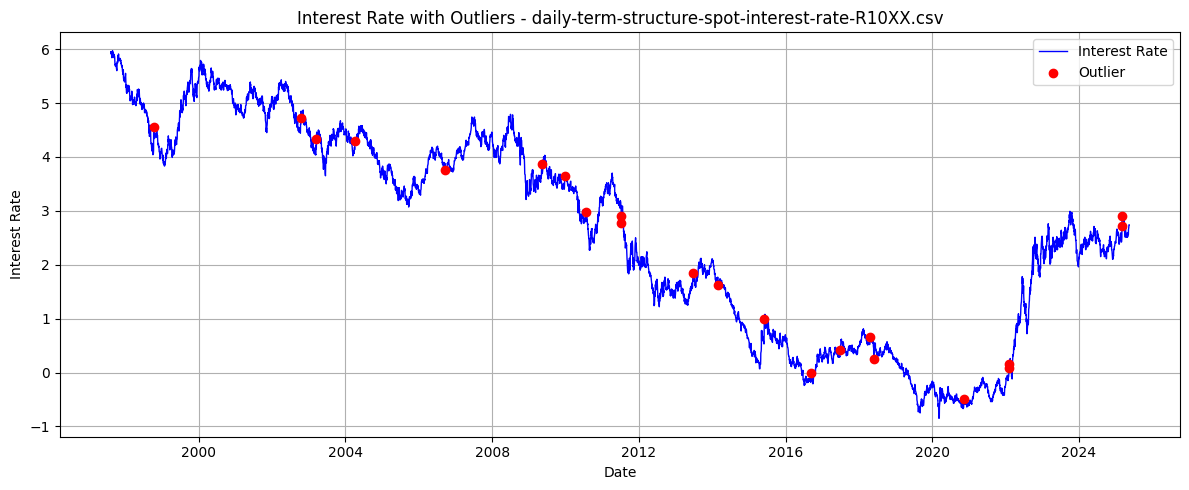

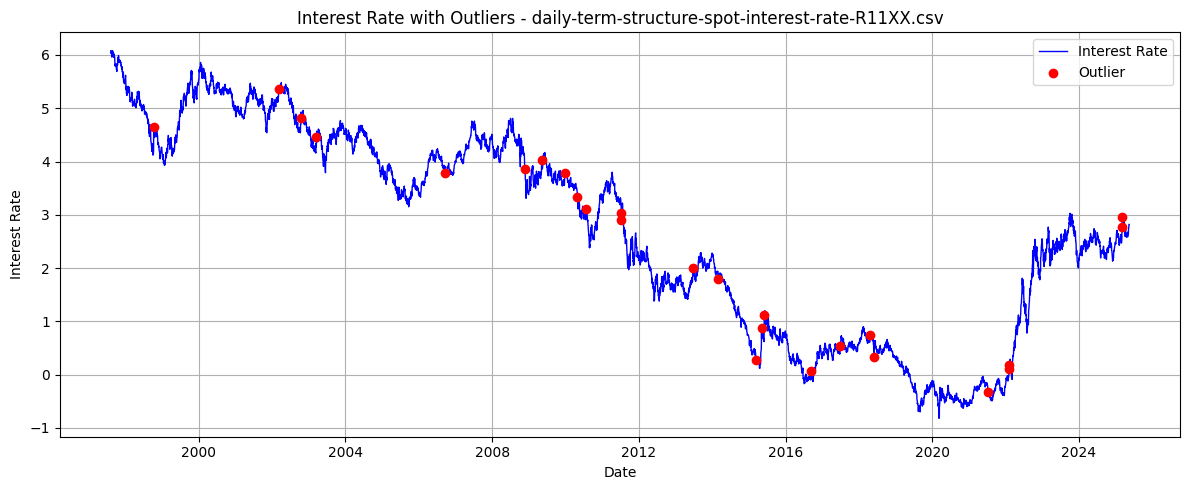

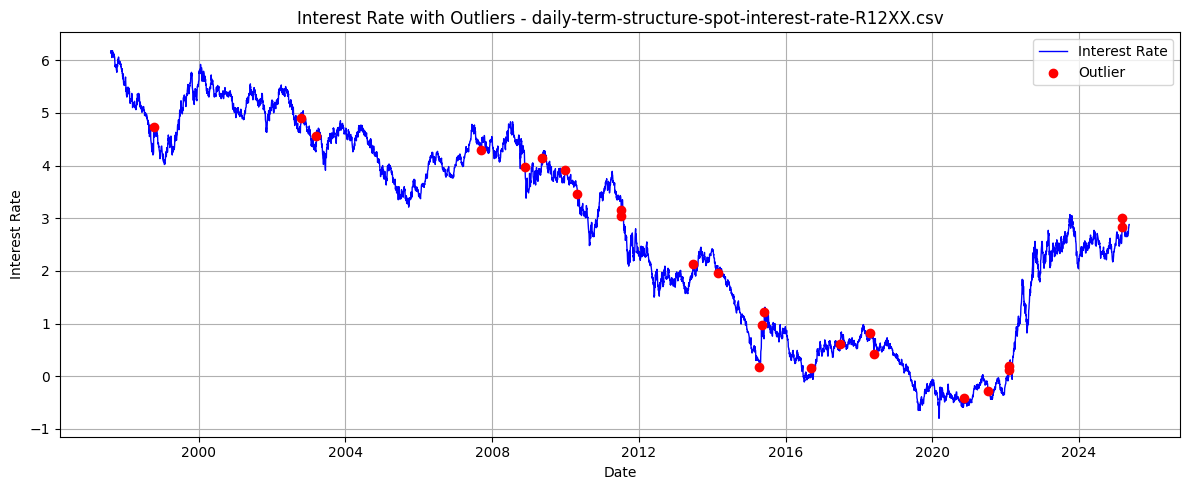

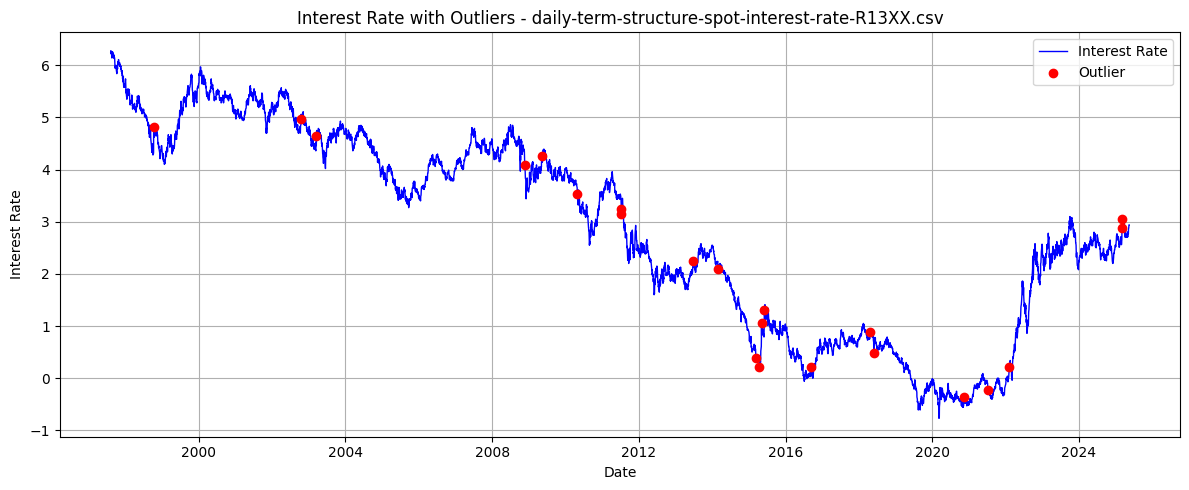

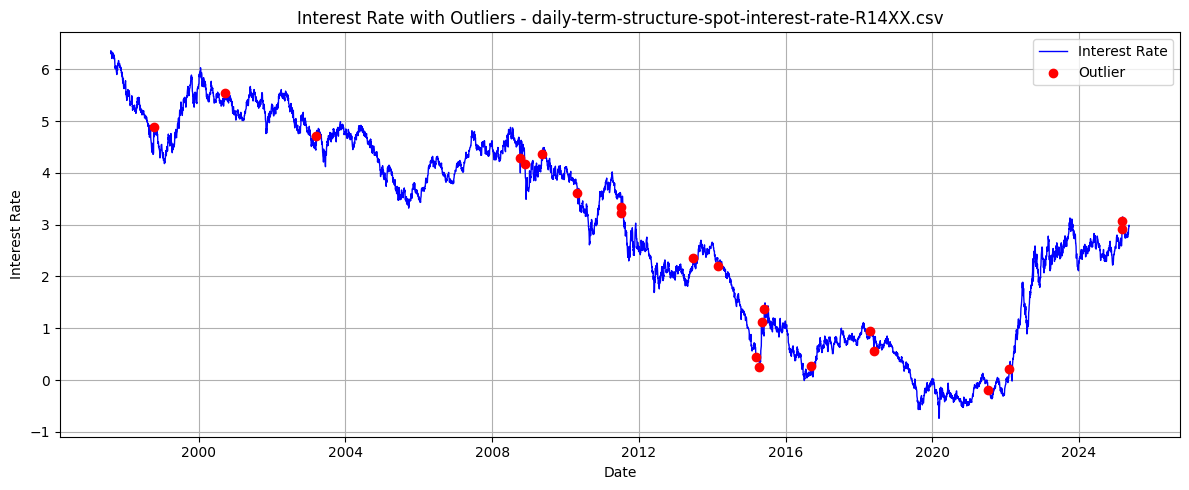

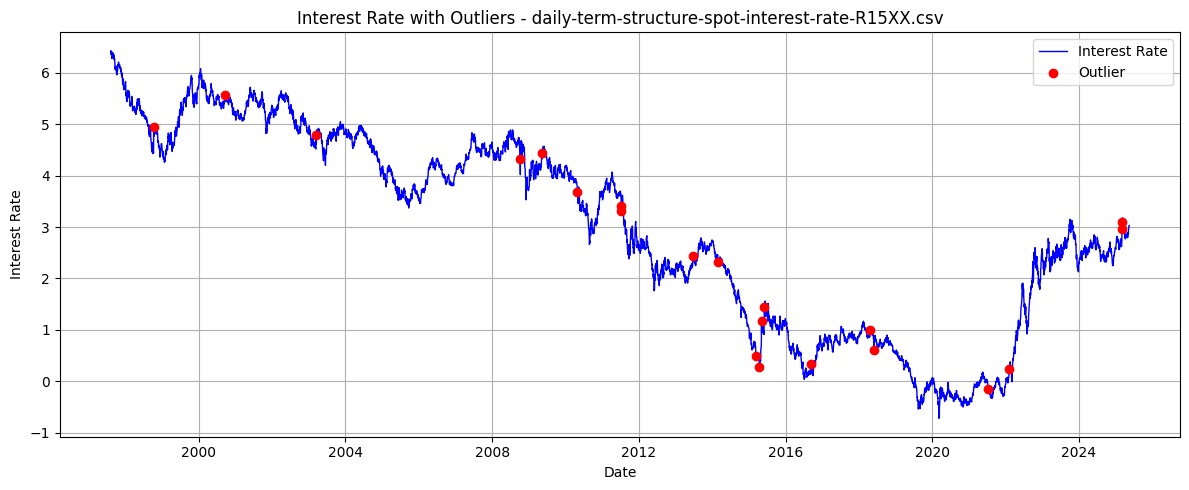

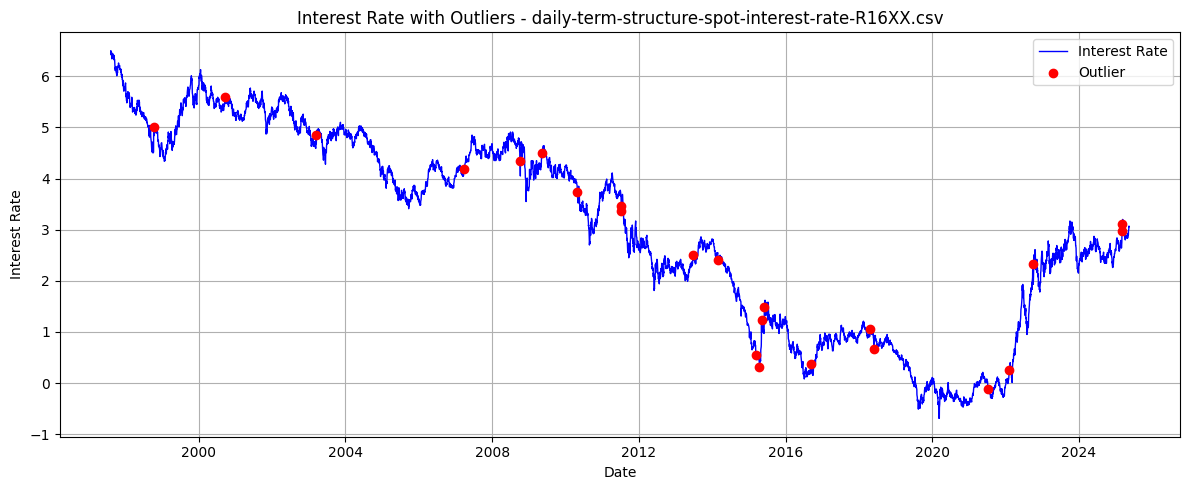

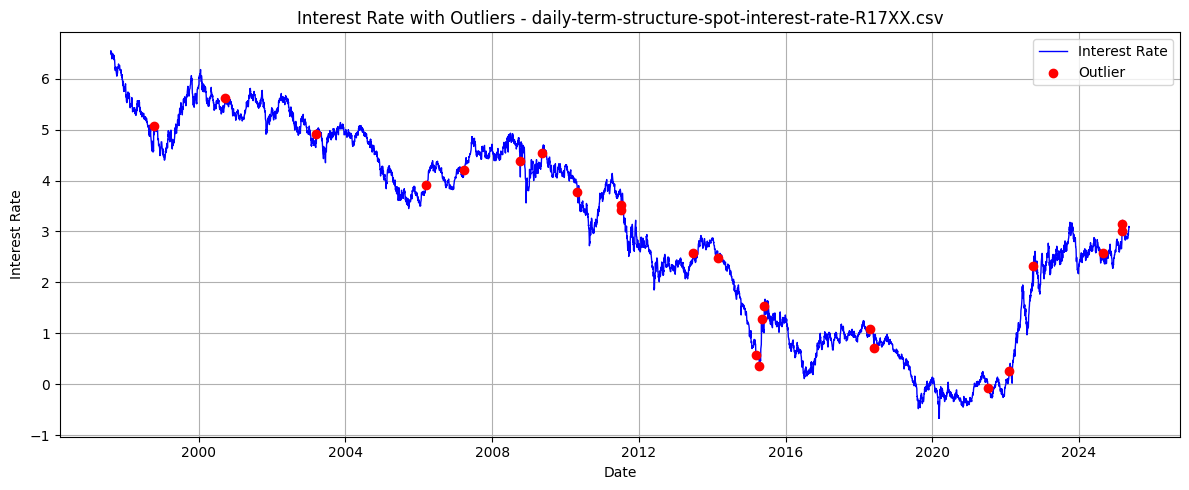

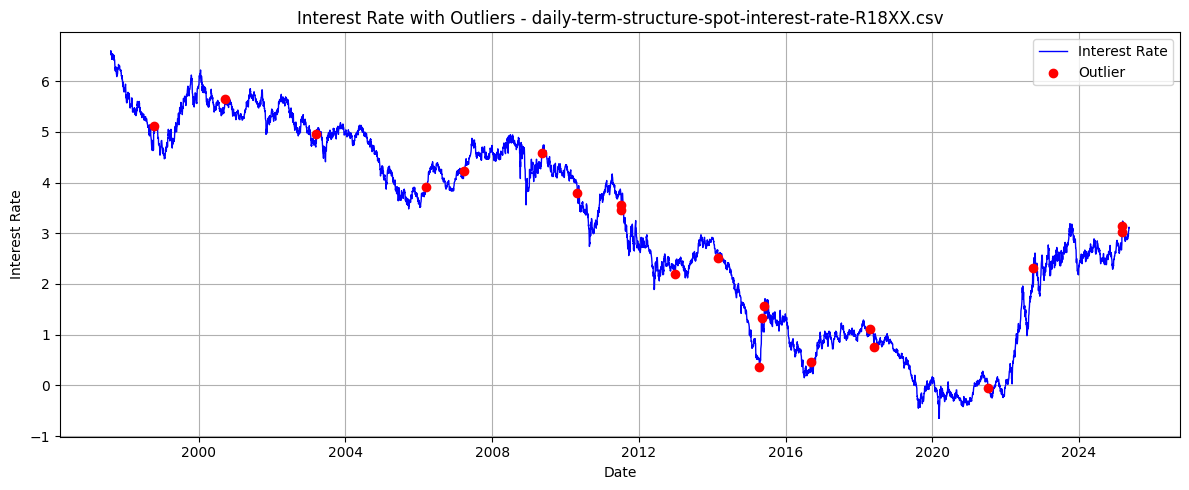

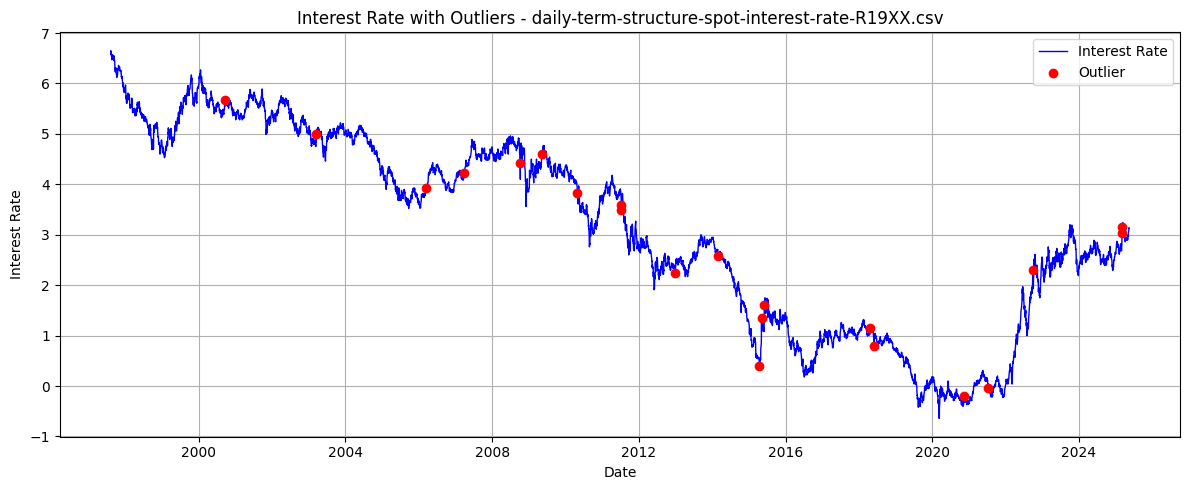

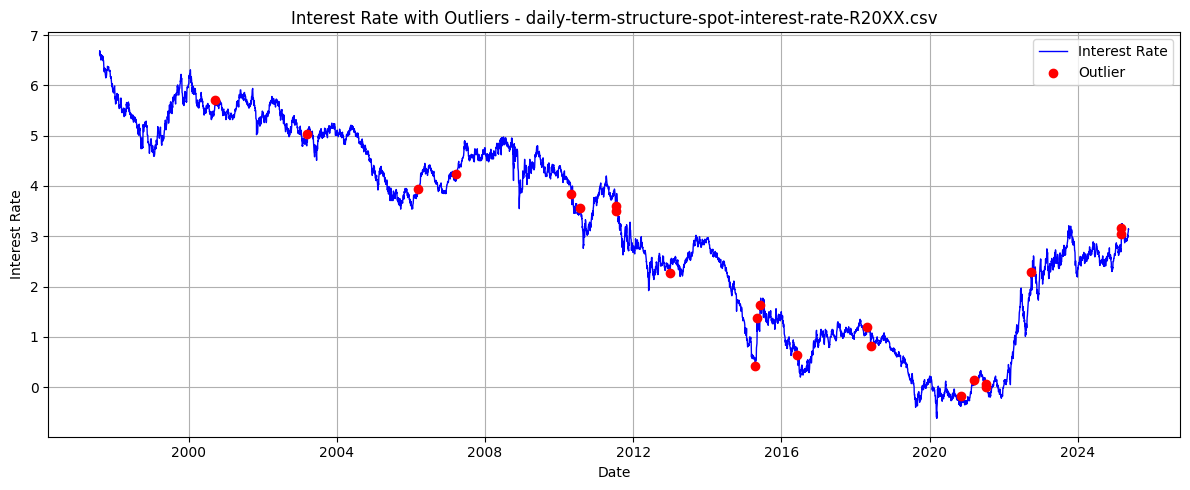

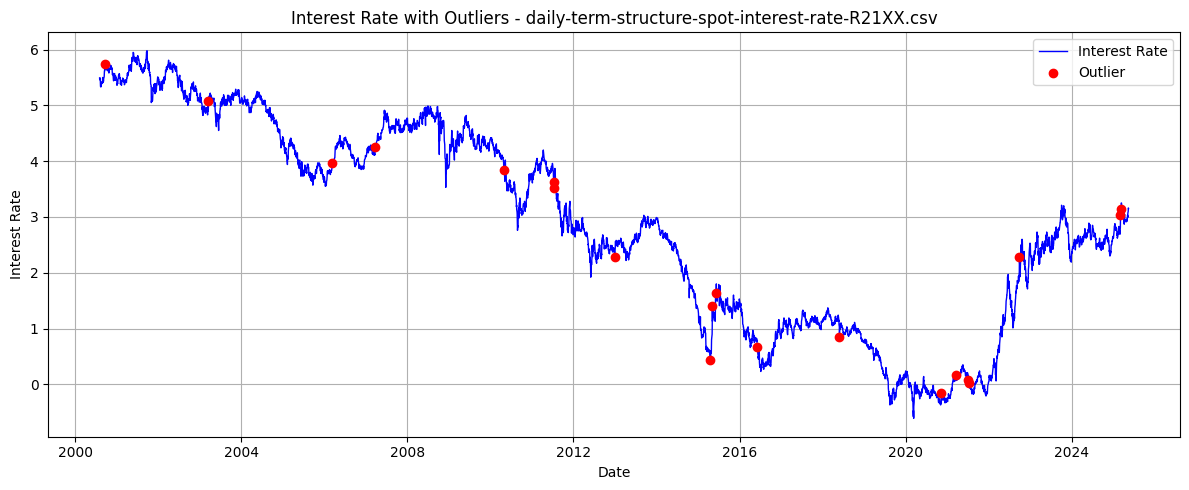

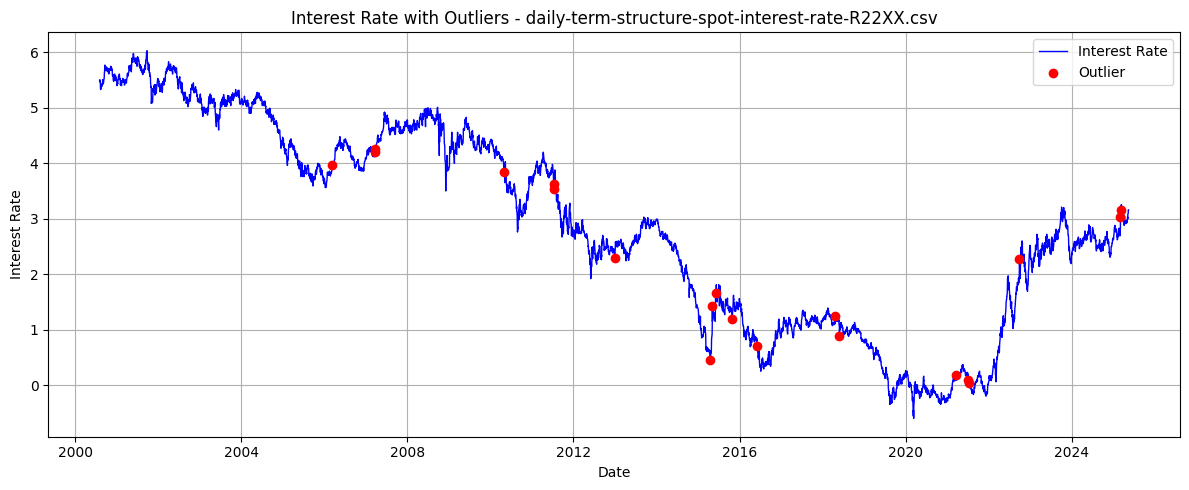

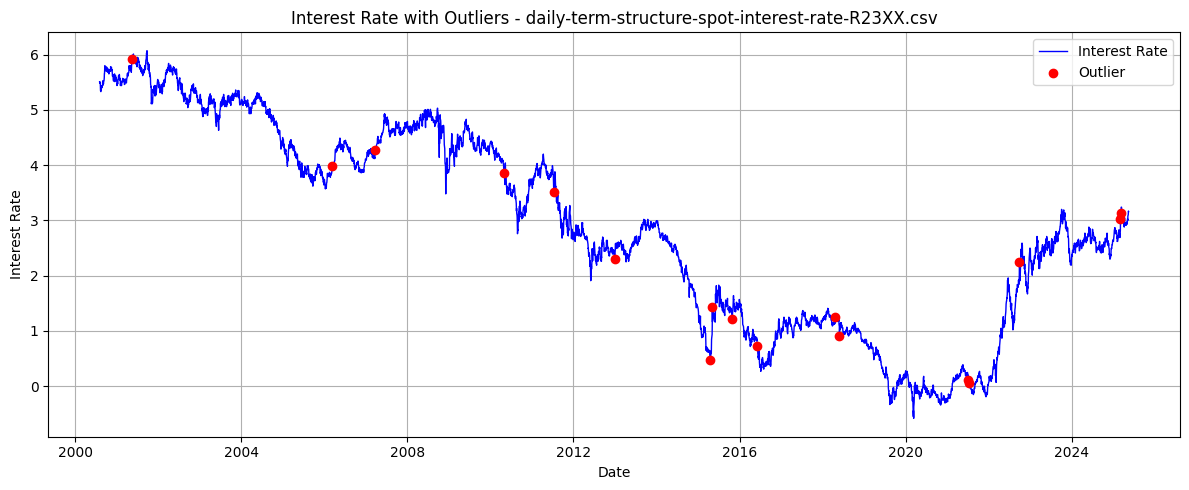

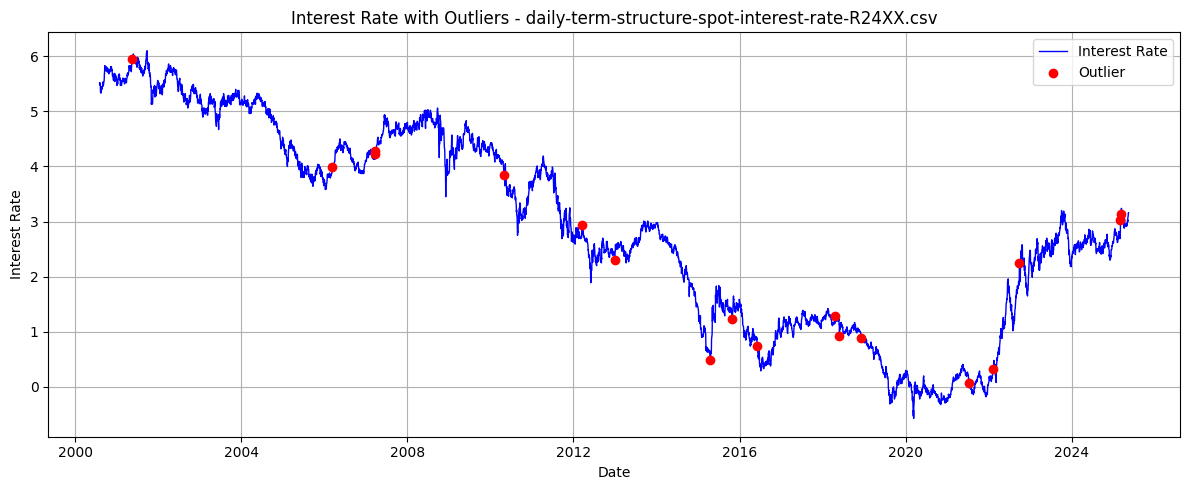

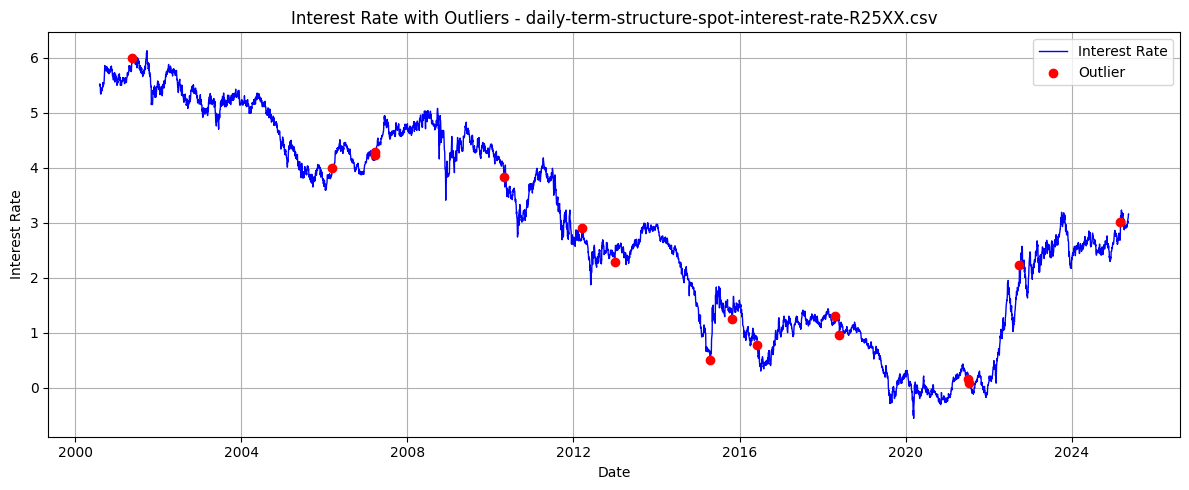

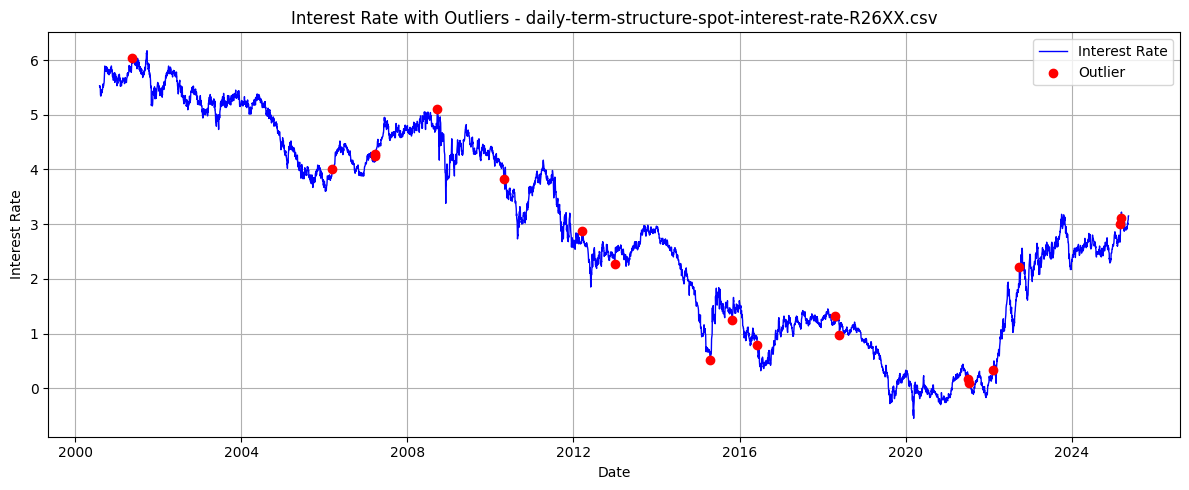

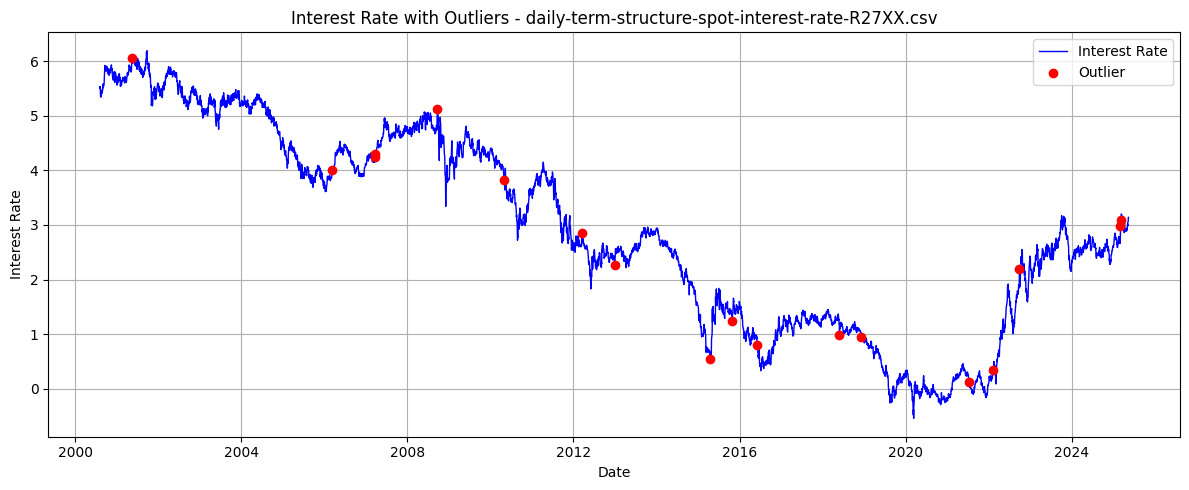

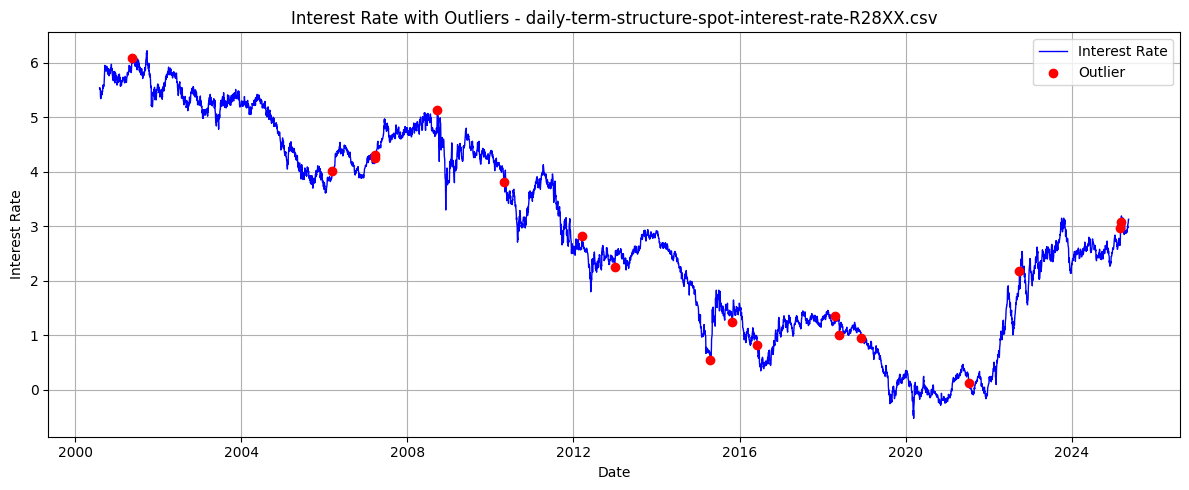

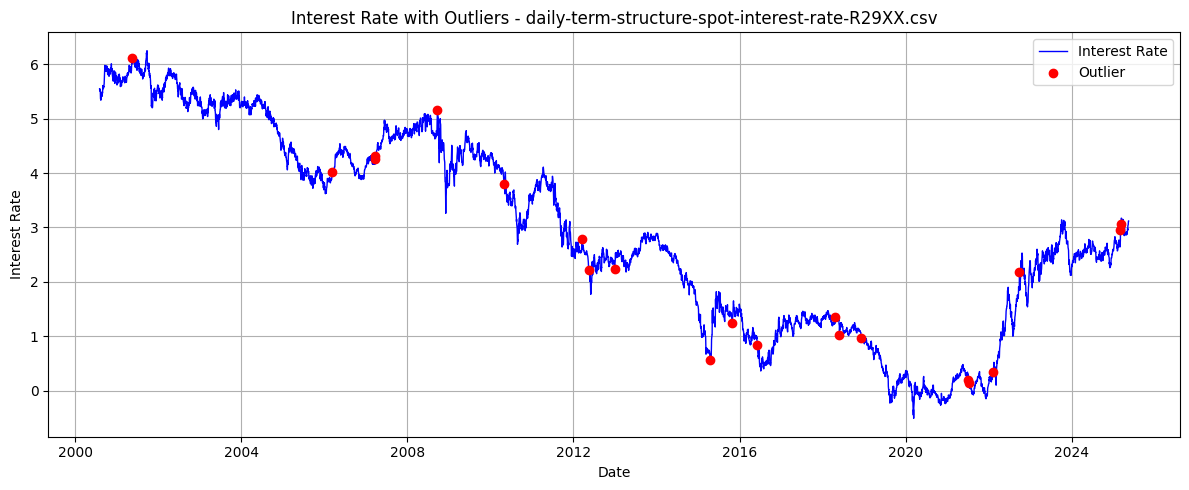

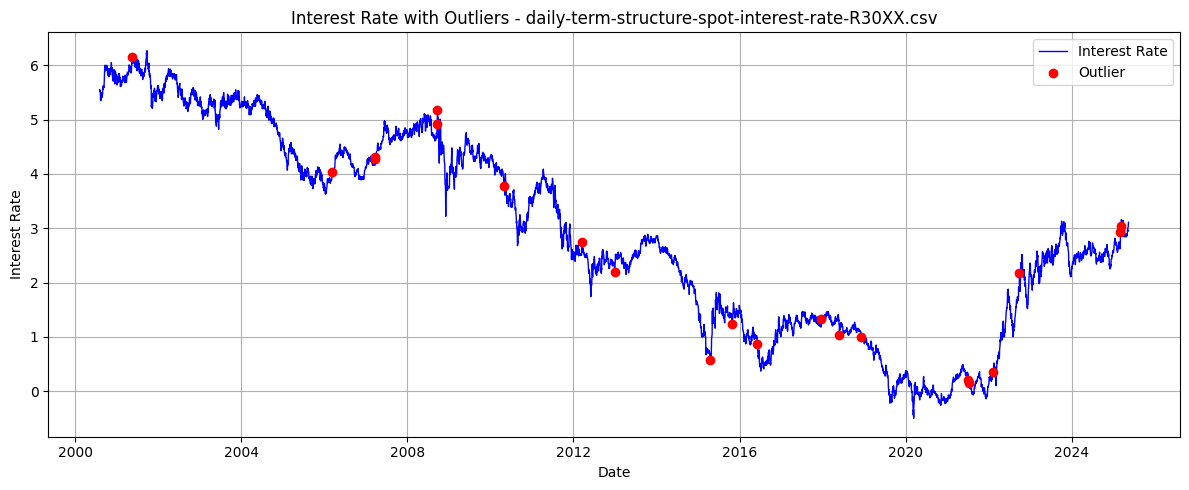

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
window_size = 20
z_threshold = 3

# Loop over all files
for i, df in enumerate(cleaned_dataframes):
    df = df.copy()  # Prevent altering original
    df.sort_values('Date', inplace=True)

    # Calculate rolling mean and std
    df['RollingMean'] = df['InterestRate'].rolling(window=window_size, min_periods=10).mean()
    df['RollingStd'] = df['InterestRate'].rolling(window=window_size, min_periods=10).std()

    # Z-score calculation
    df['ZScore'] = (df['InterestRate'] - df['RollingMean']) / df['RollingStd']

    # Identify outliers
    df['Outlier'] = df['ZScore'].abs() > z_threshold

    # Plot: interest rate with outliers
    plt.figure(figsize=(12, 5))
    plt.plot(df['Date'], df['InterestRate'], label='Interest Rate', color='blue', linewidth=1)
    plt.scatter(df.loc[df['Outlier'], 'Date'], df.loc[df['Outlier'], 'InterestRate'],
                color='red', label='Outlier', zorder=5)

    plt.title(f'Interest Rate with Outliers - {csv_files[i]}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
rolling_outlier_summary = []

for i, df in enumerate(cleaned_dataframes):
    df = df.copy()
    df['RollingMean'] = df['InterestRate'].rolling(window=20, min_periods=10).mean()
    df['RollingStd'] = df['InterestRate'].rolling(window=20, min_periods=10).std()
    df['ZScore'] = (df['InterestRate'] - df['RollingMean']) / df['RollingStd']
    df['Outlier'] = df['ZScore'].abs() > 3

    outlier_rows = df[df['Outlier']]

    rolling_outlier_summary.append({
        'File': csv_files[i],
        'Rolling Outlier Count': len(outlier_rows),
        'Max Outlier Value': outlier_rows['InterestRate'].max(),
        'Min Outlier Value': outlier_rows['InterestRate'].min()
    })

rolling_outlier_df = pd.DataFrame(rolling_outlier_summary)
display(rolling_outlier_df)


File  Rolling Outlier Count  \
0   daily-term-structure-spot-interest-rate-R005X.csv                     55   
1   daily-term-structure-spot-interest-rate-R01XX.csv                     45   
2   daily-term-structure-spot-interest-rate-R02XX.csv                     22   
3   daily-term-structure-spot-interest-rate-R03XX.csv                     19   
4   daily-term-structure-spot-interest-rate-R04XX.csv                     19   
5   daily-term-structure-spot-interest-rate-R05XX.csv                     20   
6   daily-term-structure-spot-interest-rate-R06XX.csv                     17   
7   daily-term-structure-spot-interest-rate-R07XX.csv                     19   
8   daily-term-structure-spot-interest-rate-R08XX.csv                     19   
9   daily-term-structure-spot-interest-rate-R09XX.csv                     21   
10  daily-term-structure-spot-interest-rate-R10XX.csv                     22   
11  daily-term-structure-spot-interest-rate-R11XX.csv                     26   
12  daily-term-structure-spot-interest-rate-R12XX.csv                     25   
13  daily-term-structure-spot-interest-rate-R13XX.csv                     22   
14  daily-term-structure-spot-interest-rate-R14XX.csv                     22   
15  daily-term-structure-spot-interest-rate-R15XX.csv                     21   
16  daily-term-structure-spot-interest-rate-R16XX.csv                     23   
17  daily-term-structure-spot-interest-rate-R17XX.csv                     24   
18  daily-term-structure-spot-interest-rate-R18XX.csv                     21   
19  daily-term-structure-spot-interest-rate-R19XX.csv                     21   
20  daily-term-structure-spot-interest-rate-R20XX.csv                     22   
21  daily-term-structure-spot-interest-rate-R21XX.csv                     20   
22  daily-term-structure-spot-interest-rate-R22XX.csv                     20   
23  daily-term-structure-spot-interest-rate-R23XX.csv                     17   
24  daily-term-structure-spot-interest-rate-R24XX.csv                     18   
25  daily-term-structure-spot-interest-rate-R25XX.csv                     16   
26  daily-term-structure-spot-interest-rate-R26XX.csv                     19   
27  daily-term-structure-spot-interest-rate-R27XX.csv                     18   
28  daily-term-structure-spot-interest-rate-R28XX.csv                     18   
29  daily-term-structure-spot-interest-rate-R29XX.csv                     21   
30  daily-term-structure-spot-interest-rate-R30XX.csv                     21   

    Max Outlier Value  Min Outlier Value  
0                4.97              -0.79  
1                5.13              -0.80  
2                4.45              -0.82  
3                4.77              -0.84  
4                5.01              -0.83  
5                5.19              -0.75  
6                5.34              -0.24  
7                4.68              -0.65  
8                4.49              -0.60  
9                4.61              -0.55  
10               4.72              -0.50  
11               5.36              -0.33  
12               4.90              -0.41  
13               4.97              -0.37  
14               5.54              -0.19  
15               5.57              -0.15  
16               5.59              -0.11  
17               5.62              -0.08  
18               5.65              -0.05  
19               5.68              -0.20  
20               5.71              -0.18  
21               5.74              -0.16  
22               4.26               0.04  
23               5.92               0.06  
24               5.95               0.07  
25               5.99               0.09  
26               6.03               0.10  
27               6.06               0.12  
28               6.09               0.13  
29               6.12               0.14  
30               6.15               0.15

In [ ]:
# Merge all datasets into one by 'Date' column
merged_df = pd.DataFrame()
for i, df in enumerate(cleaned_dataframes):
    temp = df[['Date', 'InterestRate']].copy()
    temp = temp.rename(columns={'InterestRate': csv_files[i]})
    if merged_df.empty:
        merged_df = temp
    else:
        merged_df = pd.merge(merged_df, temp, on='Date', how='outer')


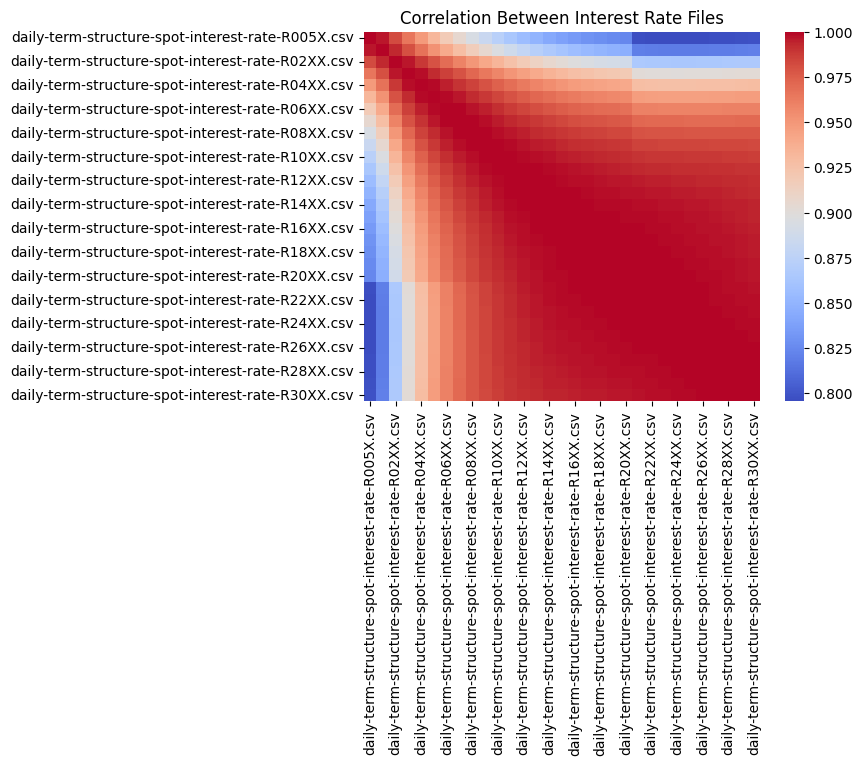

In [ ]:
# Pearson correlation matrix
correlation_matrix = merged_df.drop(columns=['Date']).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Between Interest Rate Files")
plt.show()


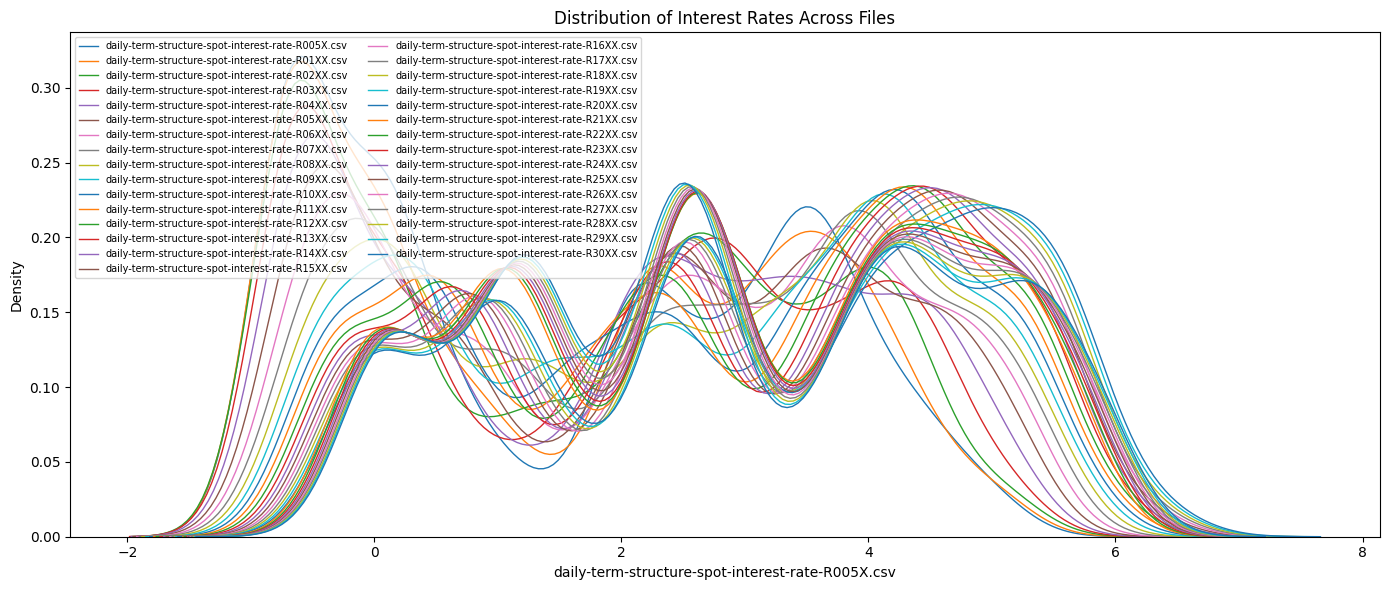

In [ ]:
plt.figure(figsize=(14, 6))
for i, col in enumerate(merged_df.columns[1:]):
    sns.kdeplot(data=merged_df[col], label=col, linewidth=1)
plt.title("Distribution of Interest Rates Across Files")
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()


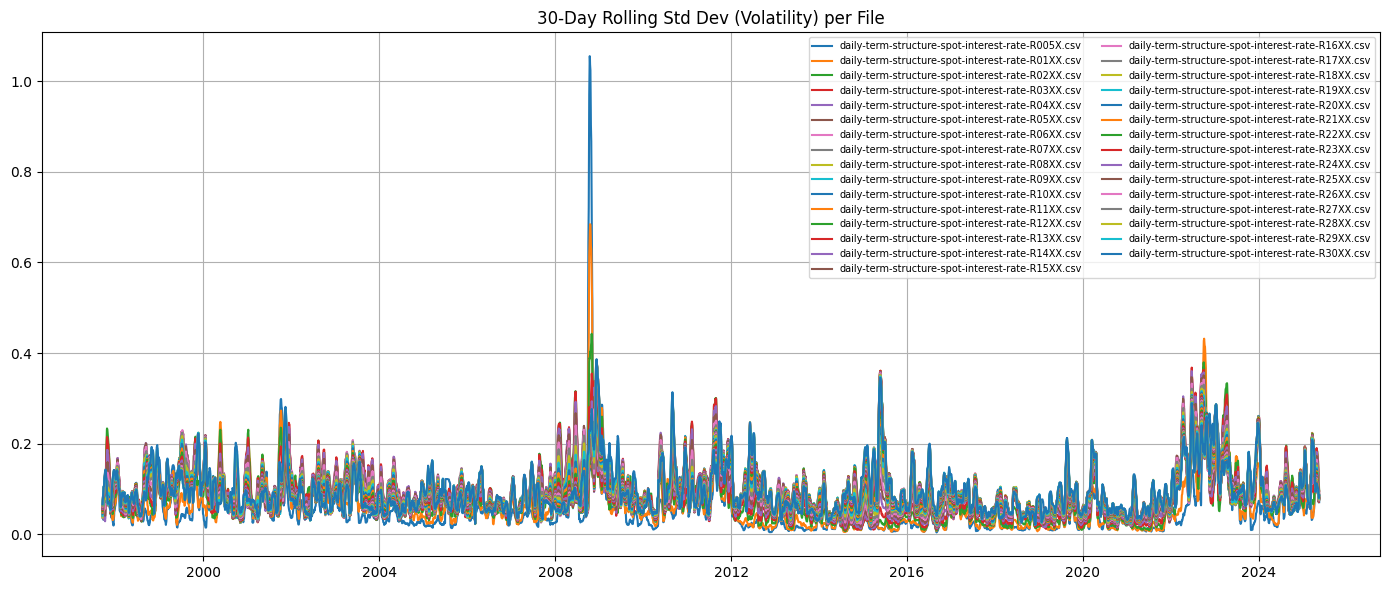

In [ ]:
plt.figure(figsize=(14, 6))
for col in merged_df.columns[1:]:
    rolling_std = merged_df[col].rolling(window=30).std()
    plt.plot(merged_df['Date'], rolling_std, label=col)
plt.title("30-Day Rolling Std Dev (Volatility) per File")
plt.legend(fontsize=7, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
